
# Seatfinder – Auswertung aus PostgreSQL-SQL-Dump (2016–2024)

**Hinweis:** Dieses Notebook benötigt **nur die `.sql`-Dump-Datei** (mit `CREATE TABLE` + `COPY ... FROM stdin;` Blöcken). Es verwendet **keine** Datenbankverbindung – der Dump wird direkt geparst und in `pandas`-DataFrames geladen.

**Was du tun musst:**  
1. Lege deine Dump-Datei (z. B. `seatfinder_dump.sql`) im gleichen Ordner ab, in dem du dieses Notebook startest, oder passe unten den Pfad in `SQL_DUMP_PATH` an.  
2. Führe die Zellen nacheinander aus.


In [2]:
SQL_DUMP_PATH = "data/seatfinder_tuebingen_2024-10-15.sql" 

import os, io, re, csv, datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Matplotlib Defaults – (keine Styles/keine Farben explizit setzen)
plt.rcParams.update({
    "figure.figsize": (9, 4.5),
    "axes.grid": True
})

assert os.path.exists(SQL_DUMP_PATH), f"SQL_DUMP_PATH nicht gefunden: {SQL_DUMP_PATH}"
print("SQL-Dump gefunden:", SQL_DUMP_PATH)

SQL-Dump gefunden: data/seatfinder_tuebingen_2024-10-15.sql



## Dump-Parser (COPY-Blöcke → DataFrames)

Der Parser liest `COPY schema.table (cols...) FROM stdin;` und sammelt die Tab-getrennten Datenzeilen bis zur Zeile `\.`.  
Leere Werte werden als `NaN` gesetzt, `\N` wird ebenfalls zu `NaN`. Datentypen werden später konvertiert.


In [3]:
import io, re

COPY_START_RE = re.compile(r'^COPY\s+([a-zA-Z0-9_\."]+)\s*\((.*?)\)\s+FROM\s+stdin;', re.IGNORECASE)
COPY_END = r'\.'

def parse_sql_dump_to_tables(sql_path):
    tables = {}  # key: full table name (e.g., public.locations) -> dict with keys: columns, rows
    current = None
    cols = []
    rows = []
    with io.open(sql_path, "r", encoding="utf-8", errors="ignore") as f:
        for raw_line in f:
            line = raw_line.rstrip("\n")
            if current is None:
                m = COPY_START_RE.match(line)
                if m:
                    current = m.group(1)  # e.g., public.locations
                    col_str = m.group(2)
                    cols = [c.strip().strip('"') for c in col_str.split(",")]
                    rows = []
            else:
                if line == COPY_END:
                    tables.setdefault(current, {"columns": cols, "rows": []})
                    tables[current]["rows"].extend(rows)
                    current = None
                    cols = []
                    rows = []
                else:
                    parts = line.split("\t")
                    if len(parts) < len(cols):
                        parts += [""] * (len(cols) - len(parts))
                    elif len(parts) > len(cols):
                        parts = parts[:len(cols)]
                    parts = [None if p == r"\N" else p for p in parts]
                    rows.append(parts)
    return tables

tables = parse_sql_dump_to_tables(SQL_DUMP_PATH)
print("Gefundene COPY-Tabellen:", list(tables.keys()))

Gefundene COPY-Tabellen: ['public.locations', 'public.manual_counts', 'public.seat_estimates', 'public.wlan_clients']



## DataFrames bauen

Wir ziehen die vier relevanten Tabellen in DataFrames:
- `public.locations`
- `public.seat_estimates`
- `public.wlan_clients`
- `public.manual_counts` (falls vorhanden)


In [4]:
def table_to_df(tables, key):
    t = tables.get(key)
    if not t:
        return None
    df = pd.DataFrame(t["rows"], columns=t["columns"])
    return df

locations = table_to_df(tables, "public.locations")
seat_estimates = table_to_df(tables, "public.seat_estimates")
wlan_clients = table_to_df(tables, "public.wlan_clients")
manual_counts = table_to_df(tables, "public.manual_counts")

for name, df in [("locations", locations), ("seat_estimates", seat_estimates),
                 ("wlan_clients", wlan_clients), ("manual_counts", manual_counts)]:
    if df is None:
        print(f"{name}: nicht im Dump gefunden")
    else:
        print(f"{name}: {df.shape}")

locations: (20, 14)
seat_estimates: (8323622, 5)
wlan_clients: (17489095, 4)
manual_counts: (1177, 5)



## Typen konvertieren

- `timestamp` → `datetime` (naiv, als Europe/Berlin interpretierbar)
- numerische Spalten → `int/float`


In [5]:
def to_datetime_safe(s):
    return pd.to_datetime(s, errors="coerce")

def to_int_safe(s):
    return pd.to_numeric(s, errors="coerce").astype("Int64")

def to_float_safe(s):
    return pd.to_numeric(s, errors="coerce")

# locations
if locations is not None:
    for c in ["id", "availableseats", "superlocation_id"]:
        if c in locations.columns:
            locations[c] = to_int_safe(locations[c])
    if "timestamp" in locations.columns:
        locations["timestamp"] = to_datetime_safe(locations["timestamp"])

# seat_estimates
if seat_estimates is not None:
    for c in ["id", "location_id", "occupiedseats", "freeseats"]:
        if c in seat_estimates.columns:
            seat_estimates[c] = to_int_safe(seat_estimates[c])
    if "timestamp" in seat_estimates.columns:
        seat_estimates["timestamp"] = to_datetime_safe(seat_estimates["timestamp"])

# wlan_clients
if wlan_clients is not None:
    for c in ["id", "location_id", "numberofclients"]:
        if c in wlan_clients.columns:
            wlan_clients[c] = to_int_safe(wlan_clients[c])
    if "timestamp" in wlan_clients.columns:
        wlan_clients["timestamp"] = to_datetime_safe(wlan_clients["timestamp"])

# manual_counts
if manual_counts is not None:
    for c in ["id", "location_id", "occupiedseats", "freeseats"]:
        if c in manual_counts.columns:
            manual_counts[c] = to_int_safe(manual_counts[c])
    if "timestamp" in manual_counts.columns:
        manual_counts["timestamp"] = to_datetime_safe(manual_counts["timestamp"])

# Nützliche Lookup-Infos
if locations is not None:
    loc_lookup = locations.set_index("id")[["name","longname","availableseats"]]
else:
    loc_lookup = pd.DataFrame()

print("Konvertierung fertig.")

Konvertierung fertig.



## (Optional) CSV-Exporte

Praktisch, wenn man die Aggregationen außerhalb des Notebooks prüfen möchte.


In [7]:
OUTDIR = "exports"
os.makedirs(OUTDIR, exist_ok=True)

if locations is not None: locations.to_csv(os.path.join(OUTDIR, "locations.csv"), index=False)
if seat_estimates is not None: seat_estimates.to_csv(os.path.join(OUTDIR, "seat_estimates.csv"), index=False)
if wlan_clients is not None: wlan_clients.to_csv(os.path.join(OUTDIR, "wlan_clients.csv"), index=False)
if manual_counts is not None: manual_counts.to_csv(os.path.join(OUTDIR, "manual_counts.csv"), index=False)

print("CSV-Exporte in:", OUTDIR)

CSV-Exporte in: exports


In [7]:
# Basis: join + casting + clipping + 5-Min-Slots
se = seat_estimates.merge(
    locations[["id","name","longname","availableseats"]],
    left_on="location_id", right_on="id", how="left"
).rename(columns={"availableseats":"capacity"})

# numeric + timestamps
se["timestamp"] = pd.to_datetime(se["timestamp"], errors="coerce")
se["occ"]  = pd.to_numeric(se["occupiedseats"], errors="coerce")
se["cap"]  = pd.to_numeric(se["capacity"], errors="coerce")

# gültige Messungen
se = se.dropna(subset=["timestamp","occ","cap"])
se = se[se["cap"] > 0]

# plausibles Intervall
se["occ"] = se["occ"].clip(lower=0, upper=se["cap"])

# 5-Minuten-Slots
se["t5"] = se["timestamp"].dt.floor("5min")



## 6) WLAN-Clients vs. belegte Plätze (Validierung/Proxy)

Join auf 5-Minuten-Slots. Standort über `SITE_NAME_WIFI` wählen.


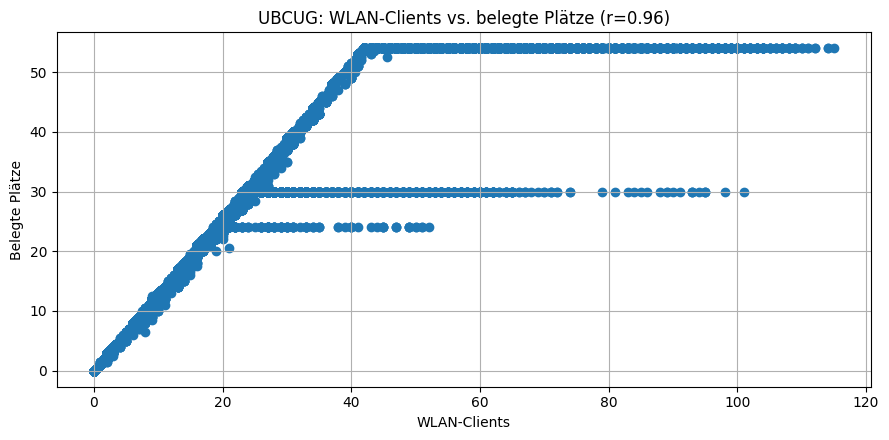

In [8]:
SITE_NAME_WIFI = "UBCUG"

se_site = se[se["name"]==SITE_NAME_WIFI].copy()
se_slot  = se_site.groupby("t5", as_index=False)["occ"].mean()

wl = wlan_clients.merge(locations[["id","name"]], left_on="location_id", right_on="id", how="left")
wl = wl[(wl["name"]==SITE_NAME_WIFI)]
wl["timestamp"] = pd.to_datetime(wl["timestamp"], errors="coerce")
wl["numberofclients"] = pd.to_numeric(wl["numberofclients"], errors="coerce")
wl = wl.dropna(subset=["timestamp","numberofclients"])
wl["t5"] = wl["timestamp"].dt.floor("5min")
wl_slot = wl.groupby("t5", as_index=False)["numberofclients"].mean()

merged = pd.merge(se_slot, wl_slot, on="t5", how="inner")

if len(merged) < 200:
    print("Zu wenige gemeinsame Slots – bitte längeren Zeitraum/anderen Standort wählen.")
else:
    r = np.corrcoef(merged["numberofclients"], merged["occ"])[0,1]
    plt.figure()
    plt.scatter(merged["numberofclients"], merged["occ"])
    plt.title(f"{SITE_NAME_WIFI}: WLAN-Clients vs. belegte Plätze (r={r:.2f})")
    plt.xlabel("WLAN-Clients"); plt.ylabel("Belegte Plätze")
    plt.tight_layout(); plt.show()



## 7) Manuelle Zählungen vs. Schätzungen (Qualitätscheck)

Jede manuelle Zählung wird der zeitnächsten Schätzung (±10 Min) zugeordnet.


In [9]:
import seaborn as sns

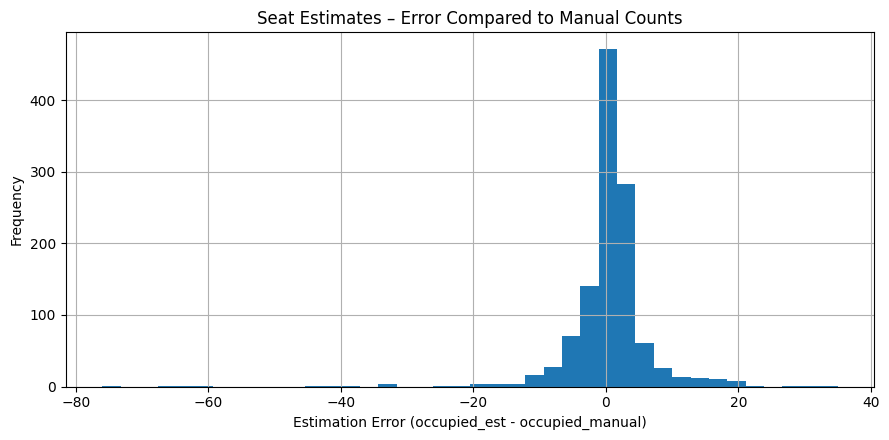

In [10]:
if manual_counts is None or manual_counts.empty:
    print("Keine 'manual_counts' im Dump – dieser Abschnitt wird übersprungen.")
else:
    mc = manual_counts.dropna(subset=["timestamp"]).copy()
    se6 = seat_estimates.copy()

    mc["left"] = mc["timestamp"] - pd.Timedelta(minutes=10)
    mc["right"] = mc["timestamp"] + pd.Timedelta(minutes=10)

    se6 = se6.dropna(subset=["timestamp"])
    merged_list = []
    for loc_id, grp in mc.groupby("location_id"):
        se_loc = se6[se6["location_id"]==loc_id]
        if se_loc.empty:
            continue
        for _, row in grp.iterrows():
            window = se_loc[(se_loc["timestamp"]>=row["left"]) & (se_loc["timestamp"]<=row["right"])]
            if window.empty: 
                continue
            idx = (window["timestamp"] - row["timestamp"]).abs().idxmin()
            best = window.loc[idx]
            merged_list.append({
                "location_id": loc_id,
                "mc_ts": row["timestamp"],
                "mc_occ": row["occupiedseats"],
                "est_ts": best["timestamp"],
                "est_occ": best["occupiedseats"]
            })
    qual = pd.DataFrame(merged_list)
    if qual.empty:
        print("Keine passenden Paare gefunden (Zeitfenster zu eng?)")
    else:
        qual["err"] = qual["est_occ"] - qual["mc_occ"]
        plt.figure()
        plt.hist(qual["err"].dropna(), bins=40)
        plt.title("Seat Estimates – Error Compared to Manual Counts")
        plt.xlabel("Estimation Error (occupied_est - occupied_manual)")
        plt.ylabel("Frequency")
        plt.tight_layout(); plt.show()

### Further Imports


In [11]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import math


plt.style.use("ggplot")


### Compute Errors with basic descriptive analysis 

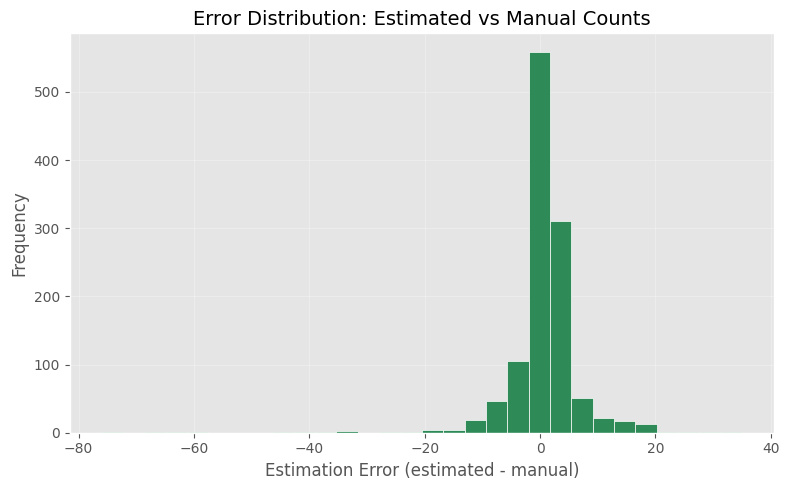

In [12]:
qual = pd.DataFrame(merged_list)
if qual.empty:
    print("Keine passenden Paare gefunden (Zeitfenster zu eng?)")
else:
    qual["err"] = qual["est_occ"] - qual["mc_occ"]

    plt.figure(figsize=(8,5))
    plt.hist(qual["err"].dropna(), bins=30, color="#2E8B57", edgecolor="white")
    plt.title("Error Distribution: Estimated vs Manual Counts", fontsize=14)
    plt.xlabel("Estimation Error (estimated - manual)", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    

#### Manual Counts Time Frame
---
1. Calculation of the time span of the manual counts
2. Calculation of the counts per day
3. Visualization



2016-04-25 10:05:31 → 2022-02-23 14:50:57
date
2016-04-25    85
2016-04-26    96
2016-04-27    77
2016-04-28    81
2016-04-29    49
              ..
2021-12-02     2
2021-12-06     1
2022-01-21     1
2022-02-21     3
2022-02-23     1
Name: count, Length: 97, dtype: int64


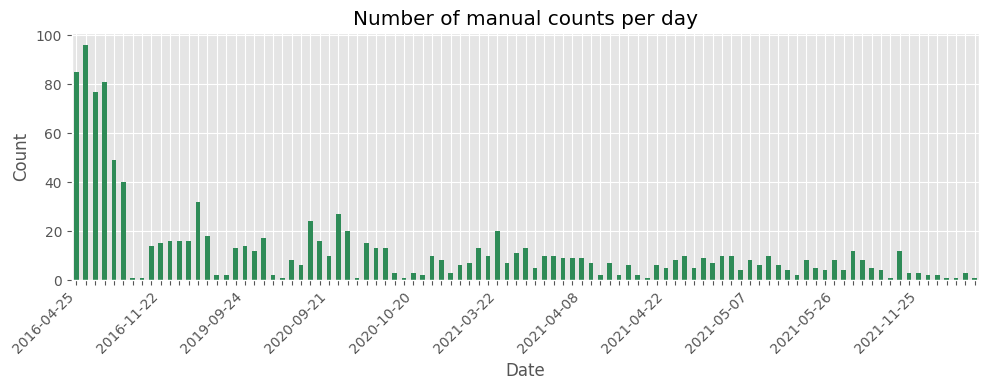

In [13]:
# See time span of manual counts
print(qual["mc_ts"].min(), "→", qual["mc_ts"].max())

# Plot counts per day
qual["date"] = qual["mc_ts"].dt.date
print(qual["date"].value_counts().sort_index())

# visualize
ax = qual["date"].value_counts().sort_index().plot(kind="bar", figsize=(10,4), color="#2E8B57")
plt.title("Number of manual counts per day")
plt.xlabel("Date")
plt.ylabel("Count")

# show only every 10th label
step = max(1, len(ax.get_xticks()) // 10)
for i, label in enumerate(ax.get_xticklabels()):
    label.set_visible(i % step == 0)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

#### Lets have a closer look to the manual counts done at the 25.04.2016 and 25.11.2021
1. choose days where manual counting was done
2. Filter each manual count with according timestamp and location id 

In [15]:
# set date
first_date_to_check = "2016-04-25"   
second_date_to_check = "2021-11-25"   

# Filter manual counts for that date
mc_day_first = mc[mc["timestamp"].dt.date == pd.to_datetime(first_date_to_check).date()]
mc_day_second = mc[mc["timestamp"].dt.date == pd.to_datetime(second_date_to_check).date()]

print(f"Manual counts on {first_date_to_check}: {len(mc_day_first)} entries")
display(mc_day_first[["timestamp", "location_id", "occupiedseats"]].sort_values("timestamp"))
print(f"Manual counts on {second_date_to_check}: {len(mc_day_second)} entries")
display(mc_day_second[["timestamp", "location_id", "occupiedseats"]].sort_values("timestamp"))


Manual counts on 2016-04-25: 94 entries


,timestamp,location_id,occupiedseats
1,2016-04-25 10:03:55,4,6
2,2016-04-25 10:04:11,5,26
3,2016-04-25 10:04:28,12,2
4,2016-04-25 10:04:37,13,12
5,2016-04-25 10:04:46,14,7
...,...,...,...
90,2016-04-25 23:06:52,16,2
91,2016-04-25 23:07:39,4,2
92,2016-04-25 23:08:59,5,9
93,2016-04-25 23:12:54,2,7


Manual counts on 2021-11-25: 3 entries


,timestamp,location_id,occupiedseats
1164,2021-11-25 09:53:04,5,8
1165,2021-11-25 09:57:06,1,54
1166,2021-11-25 09:58:42,2,29


#### lets have a closer look at the accuracy of the estimation 
1. basic scatter plot of the manual vs. estimated counts
2. calculation of basic error statistics as mean, std, min, max, 25%-, 50%-, 75%-quantile
3. calculation of the correlation
4. calculation of the correlation per location
5. visualisation of the correlation per location with scatter plots

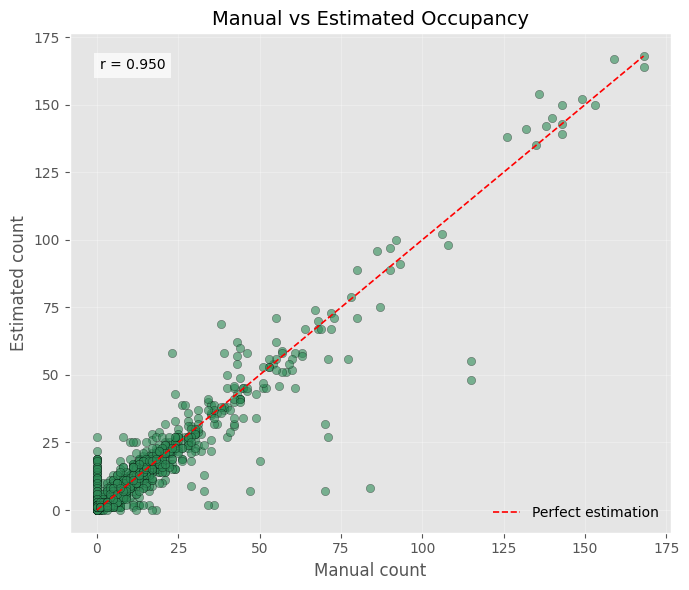

In [16]:
plt.figure(figsize=(7,6))

# scatter
plt.scatter(
    qual["mc_occ"],
    qual["est_occ"],
    alpha=0.6,
    color="#2E8B57",  # your dark green
    edgecolor="k",
    linewidth=0.3
)

# diagonal reference line
lim = [0, qual[["mc_occ","est_occ"]].max().max()]
plt.plot(lim, lim, "r--", lw=1.2, label="Perfect estimation")

# correlation
corr = qual["mc_occ"].corr(qual["est_occ"])
plt.text(
    0.05, 0.95, f"r = {corr:.3f}",
    transform=plt.gca().transAxes,
    fontsize=10,
    verticalalignment="top",
    bbox=dict(facecolor="white", alpha=0.7, edgecolor="none")
)

plt.xlabel("Manual count", fontsize=12)
plt.ylabel("Estimated count", fontsize=12)
plt.title("Manual vs Estimated Occupancy", fontsize=14)
plt.legend(frameon=False)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [17]:
# basic descriptive analysis
print(" Error Statistics ")
display(qual["err"].describe())

# Correlation
corr = qual["est_occ"].corr(qual["mc_occ"])
print(f"\nCorrelation coefficient (overall): {corr:.3f}")

# By location
print("\n=== Correlation per location ===")
corr_loc = qual.groupby("location_id").apply(
    lambda x: x["est_occ"].corr(x["mc_occ"])
)
display(corr_loc)

 Error Statistics 


count    1166.00000
mean        0.43482
std         6.91807
min       -76.00000
25%        -1.00000
50%         1.00000
75%         2.00000
max        35.00000
Name: err, dtype: float64


Correlation coefficient (overall): 0.950

=== Correlation per location ===


/var/folders/9t/s3bwp7yx0j15db_p91_vyh680000gn/T/ipykernel_95701/3927247948.py:11: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  corr_loc = qual.groupby("location_id").apply(


location_id
1     0.983609
2     0.730461
3     0.667515
4     0.829573
5     0.884242
6     0.863419
7     0.919293
8     0.924058
9     0.846269
10    0.871450
11    0.922723
12    0.821521
13    0.880732
14    0.845321
15    0.778972
16    0.711979
17    0.916321
18    0.829747
19    0.919003
20    0.920673
dtype: float64

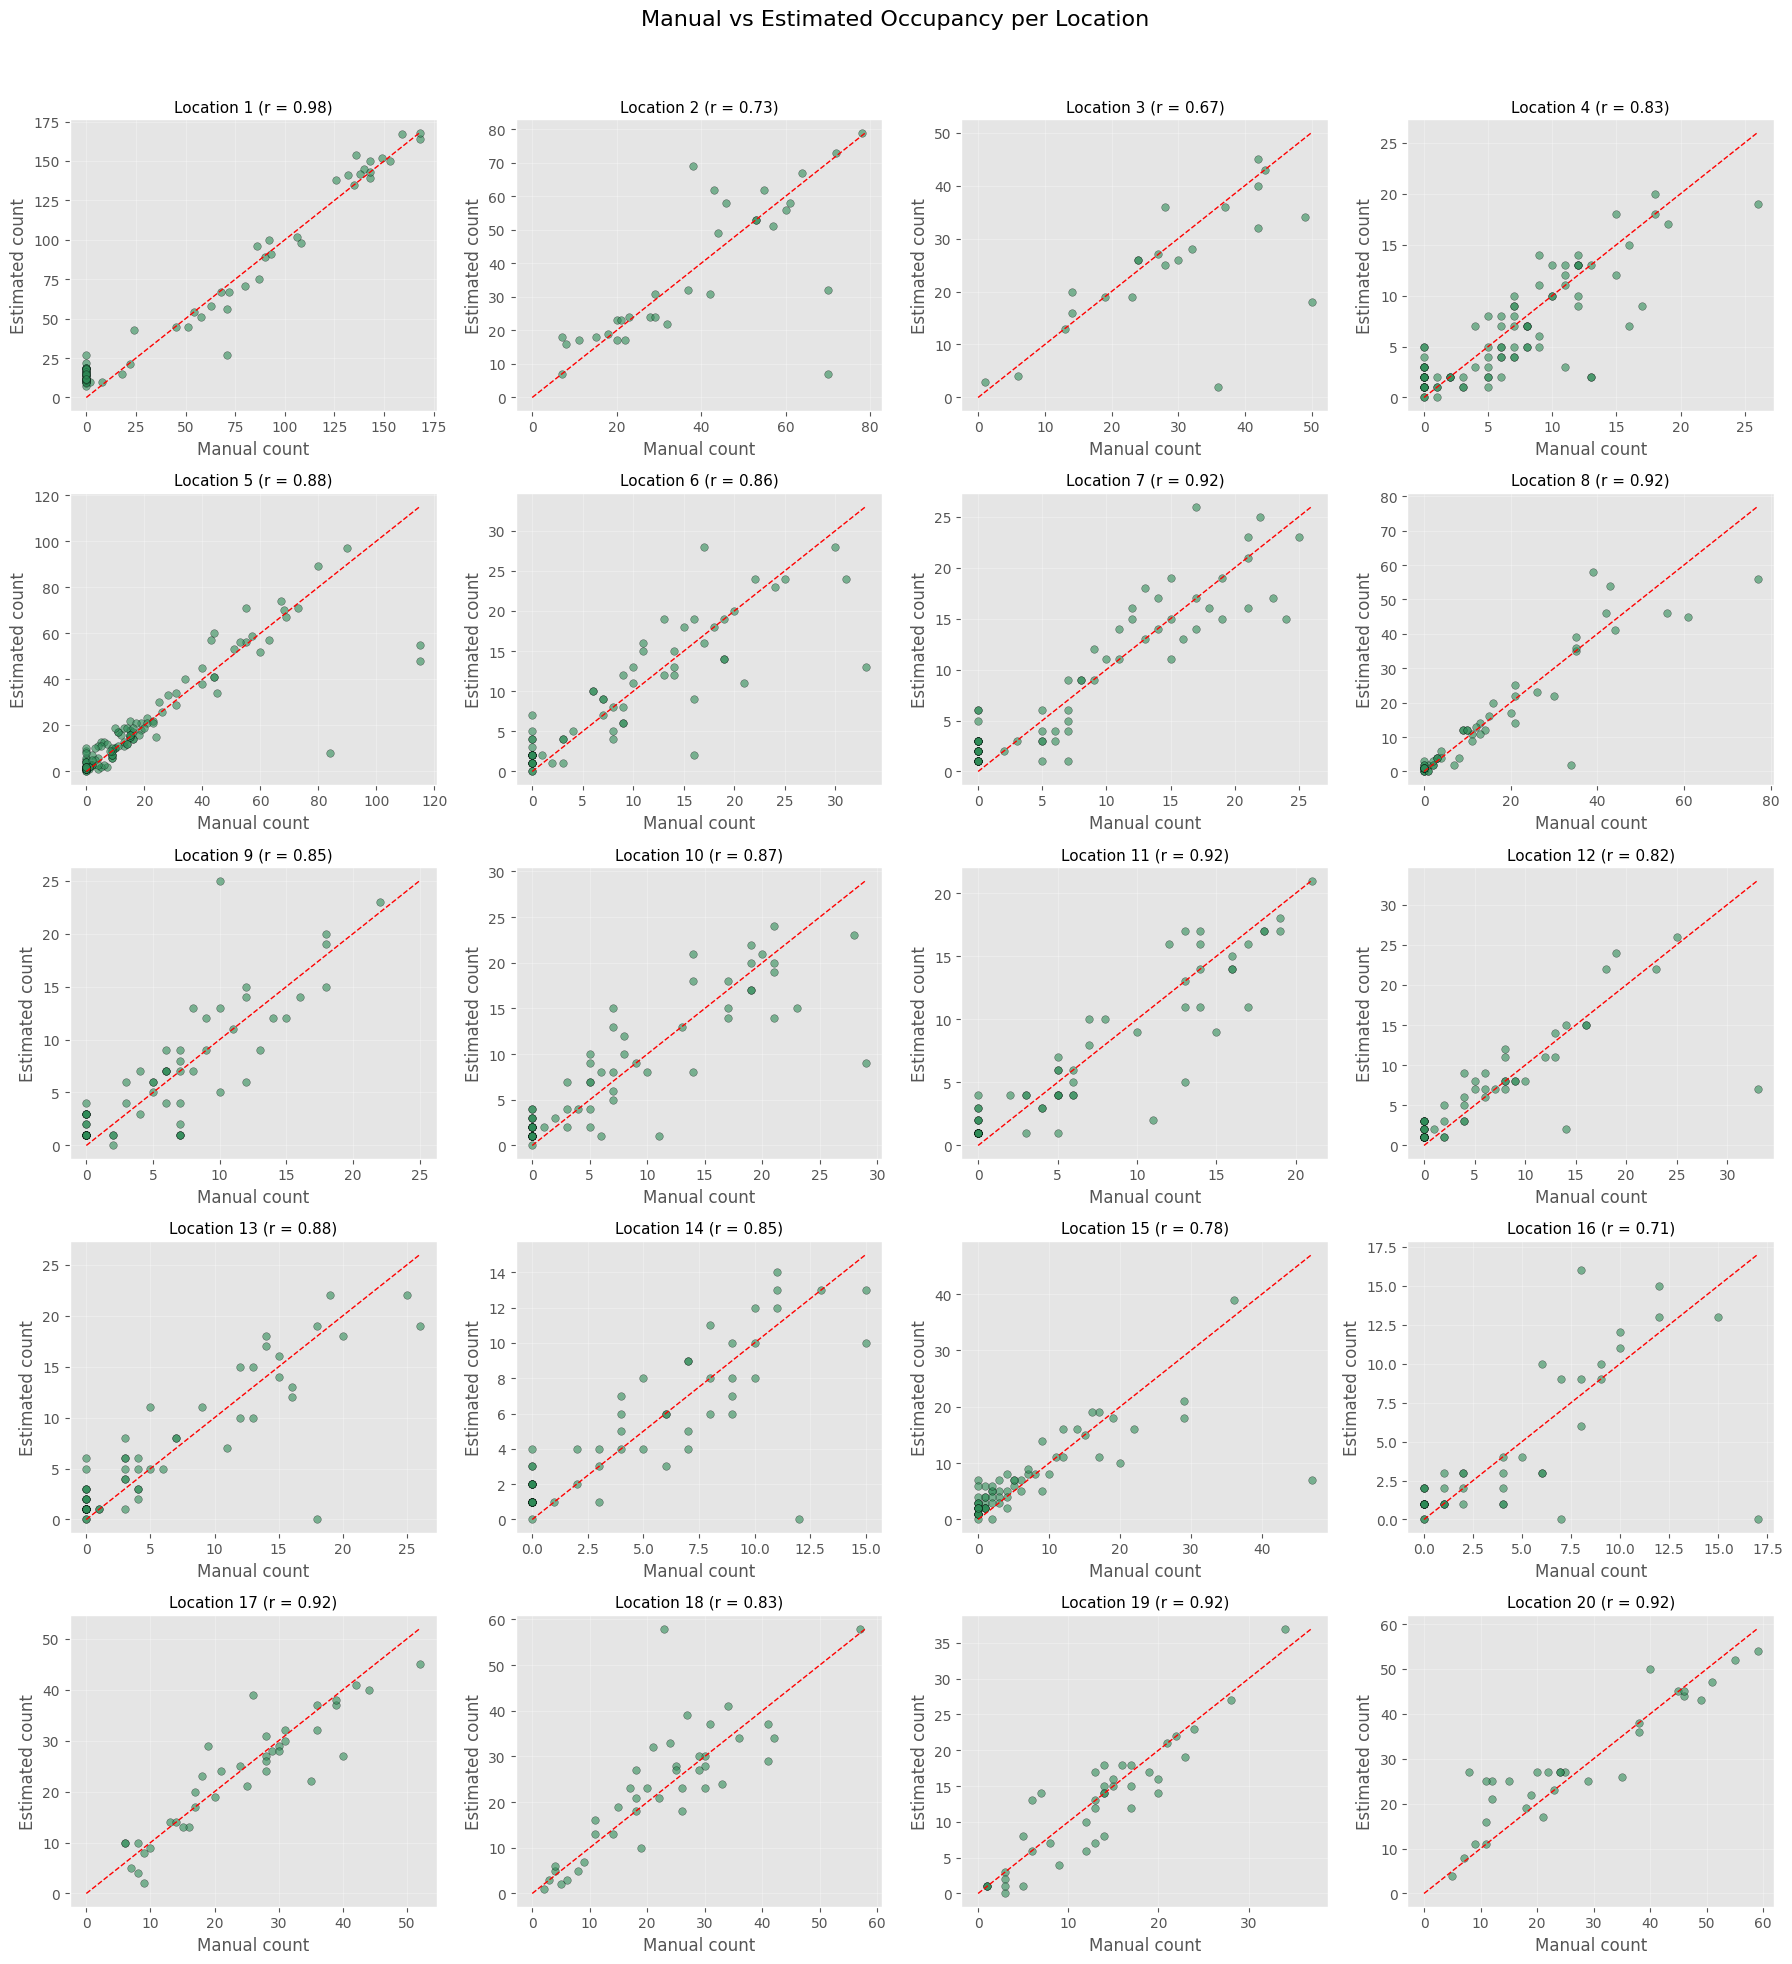

In [18]:
locations = sorted(qual["location_id"].unique())
n_locs = len(locations)

cols = 4  
rows = math.ceil(n_locs / cols)

fig, axes = plt.subplots(rows, cols, figsize=(18, 4*rows))
axes = axes.flatten()

for i, loc_id in enumerate(locations):
    ax = axes[i]
    subset = qual[qual["location_id"] == loc_id]
    
    ax.scatter(
        subset["mc_occ"],
        subset["est_occ"],
        alpha=0.6,
        color="#2E8B57",
        edgecolor="k",
        linewidth=0.3,
        s=30
    )
    
    # reference diagonal
    lim = [0, subset[["mc_occ","est_occ"]].max().max()]
    ax.plot(lim, lim, "r--", lw=1)
    
    # correlation for title
    corr = subset["mc_occ"].corr(subset["est_occ"])
    ax.set_title(f"Location {loc_id} (r = {corr:.2f})", fontsize=11)
    ax.set_xlabel("Manual count")
    ax.set_ylabel("Estimated count")
    ax.grid(alpha=0.3)

# remove empty axes if any
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Manual vs Estimated Occupancy per Location", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#### take a closer look at the top ten outliers with highest error
- What we can see is, that these are mainly from two days and a small time frame (maybe there was something wrong with the internet connection that day)

In [19]:
top_err = qual.reindex(qual["err"].abs().sort_values(ascending=False).index)
display(top_err.head(10)[["location_id", "mc_ts", "est_ts", "mc_occ", "est_occ", "err"]])


,location_id,mc_ts,est_ts,mc_occ,est_occ,err
245,5,2020-09-09 14:18:22,2020-09-09 14:18:22,84,8,-76
232,5,2016-04-30 16:52:56,2016-04-30 16:52:56,115,48,-67
95,2,2020-09-09 14:22:44,2020-09-09 14:22:44,70,7,-63
233,5,2016-04-30 16:53:11,2016-04-30 16:53:11,115,55,-60
30,1,2020-09-09 14:17:19,2020-09-09 14:17:19,71,27,-44
934,15,2020-09-09 14:21:05,2020-09-09 14:21:05,47,7,-40
89,2,2016-04-30 16:46:53,2016-04-30 16:46:53,70,32,-38
1056,18,2016-04-25 13:09:23,2016-04-25 13:07:11,23,58,35
121,3,2020-09-09 14:22:32,2020-09-09 14:22:32,36,2,-34
116,3,2016-04-30 16:47:44,2016-04-30 16:47:44,50,18,-32


#### Bias evaluation, confidence interval 
1. Calculation of mean, std, confidence intervall, MAE, RMSE

In [20]:
# bias and percision evaluation

mean_err = qual["err"].mean()
std_err = qual["err"].std()
n = len(qual)

# 95% confidence interval for mean error
ci_low = mean_err - 1.96 * std_err / np.sqrt(n)
ci_high = mean_err + 1.96 * std_err / np.sqrt(n)

print("Bias and Confidence interval")
print(f"Mean error: {mean_err:.2f}")
print(f"Standard deviation: {std_err:.2f}")
print(f"95% confidence interval for mean error: [{ci_low:.2f}, {ci_high:.2f}]")

mae = np.mean(np.abs(qual["err"]))
rmse = np.sqrt(np.mean(qual["err"]**2))



print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Square Error (RMSE): {rmse:.2f}")




Bias and Confidence interval
Mean error: 0.43
Standard deviation: 6.92
95% confidence interval for mean error: [0.04, 0.83]
Mean Absolute Error (MAE): 3.61
Root Mean Square Error (RMSE): 6.93


- Mean error: 0.43 -> average estimation of occupied seats is 0.43 higher and therefore is no systemic bias 
- Standard deviation: 6.92 -> estimation error vary around +/- 7 seats around the mean 
- 95% confidence interval for mean error: [0.04, 0.83] -> the true error bias lies in this interval and because its close to zero we can assume that the estimator is unbiased 
- Mean Absolute Error (MAE): 3.61 -> the typical estimation is around 3-4 seats off
- Root Mean Square Error (RMSE): 6.93 -> RMSE and SD almost identical because there is almost no bias

#### how many times were zero people counted but estimated more - Are some people using the internet of the librarys without being in the library ?

In [21]:
zero_manual = qual[qual["mc_occ"] == 0].copy()

print(f"Number of observations with manual count = 0: {len(zero_manual)}")
display(zero_manual[["location_id", "mc_ts", "est_ts", "mc_occ", "est_occ"]]
        .sort_values(["location_id", "mc_ts"]))


Number of observations with manual count = 0: 319


,location_id,mc_ts,est_ts,mc_occ,est_occ
31,1,2020-09-18 13:02:12,2020-09-18 13:02:12,0,11
33,1,2021-03-19 13:00:11,2021-03-19 13:00:11,0,19
34,1,2021-03-22 13:03:49,2021-03-22 13:03:49,0,14
35,1,2021-03-24 13:01:00,2021-03-24 13:01:00,0,15
36,1,2021-03-25 12:59:34,2021-03-25 12:59:34,0,14
...,...,...,...,...,...
1010,16,2021-04-01 12:58:44,2021-04-01 12:58:44,0,1
1011,16,2021-04-16 13:04:46,2021-04-16 13:04:46,0,1
1012,16,2021-04-28 12:57:21,2021-04-28 12:57:21,0,1
1013,16,2021-05-04 12:59:47,2021-05-04 12:59:47,0,2


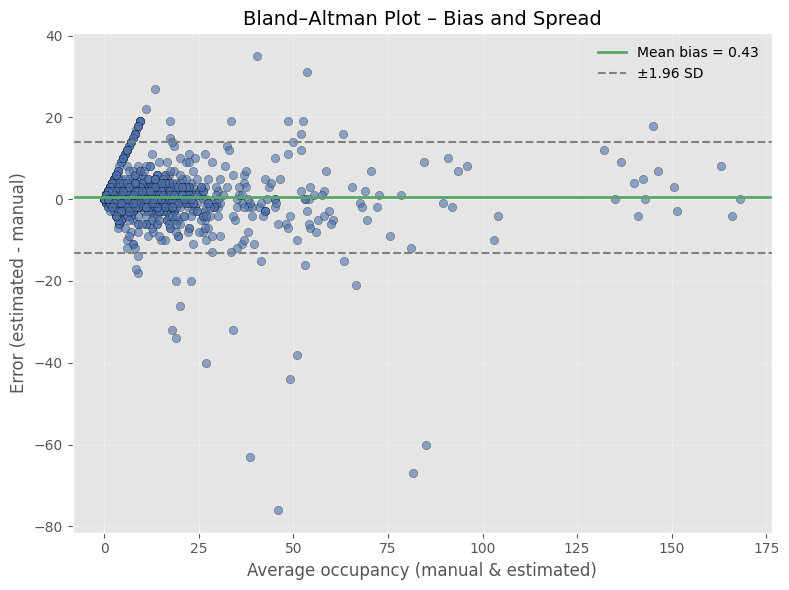

In [22]:
# bland - altmann plot 
mean_occ = (qual["est_occ"] + qual["mc_occ"]) / 2

plt.figure(figsize=(8,6))
plt.scatter(mean_occ, qual["err"], alpha=0.6, color="#4C72B0", edgecolor="k", linewidth=0.3)
plt.axhline(mean_err, color="#55A868", lw=2, label=f"Mean bias = {mean_err:.2f}")
plt.axhline(mean_err + 1.96*std_err, color="gray", linestyle="--", label="±1.96 SD")
plt.axhline(mean_err - 1.96*std_err, color="gray", linestyle="--")
plt.xlabel("Average occupancy (manual & estimated)", fontsize=12)
plt.ylabel("Error (estimated - manual)", fontsize=12)
plt.title("Bland–Altman Plot – Bias and Spread", fontsize=14)
plt.legend(frameon=False)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Alogorithm Analysis
The estimation is based on a proportional factor of the WLAN Clients and get updated over time because people tend to have more technical devices over time. 

1. merge wlan_clients and seat_estimates
2. calculate the proportional factor for every location

Questions: 
- Did the factor change over time? (with increasing devices)
- Are there different factors for different librarys (maybe in some librarys laptops aren't used that often?)


In [65]:
# taking a quick look at the wlan_clients data frame 
print(wlan_clients.columns)
print(wlan_clients.head())
print(wlan_clients.dtypes)

print(wlan_clients.groupby("location_id").size())
print(wlan_clients.groupby("location_id")["timestamp"].agg(["min", "max"]))

for loc in sorted(wlan_clients["location_id"].unique()):
    sub = wlan_clients[wlan_clients["location_id"]==loc].sort_values("timestamp")
    diffs = sub["timestamp"].diff().dropna()
    print(f"location {loc}: median interval = {diffs.median()}")


Index(['id', 'location_id', 'numberofclients', 'timestamp'], dtype='object')
   id  location_id  numberofclients           timestamp
0   5           18               32 2016-04-12 13:01:09
1   6           17               37 2016-04-12 13:01:09
2   7           19               14 2016-04-12 13:01:09
3   8           20               42 2016-04-12 13:01:09
4   9           15               15 2016-04-12 13:01:09
id                          Int64
location_id                 Int64
numberofclients             Int64
timestamp          datetime64[ns]
dtype: object
location_id
1     882937
2     882270
3     859492
4     882437
5     881648
6     883652
7     883606
8     883325
9     882495
10    878653
11    878953
12    882793
13    880767
14    872087
15    883079
16    880397
17    867406
18    798930
19    863785
20    880383
dtype: int64
                            min                 max
location_id                                        
1           2016-04-12 13:01:09 2024-10-15 13:16

In [67]:
seat_estimates.groupby("location_id")["timestamp"].agg(["min", "max"])
print("SEATS sampling:")
for loc in sorted(seat_estimates["location_id"].unique()):
    sub = seat_estimates[seat_estimates["location_id"]==loc].sort_values("timestamp")
    diffs = sub["timestamp"].diff().dropna()
    print(f"location {loc}: median interval = {diffs.median()}")


SEATS sampling:
location 1: median interval = 0 days 00:05:27
location 2: median interval = 0 days 00:05:24
location 3: median interval = 0 days 00:05:26
location 4: median interval = 0 days 00:05:26
location 5: median interval = 0 days 00:05:26
location 6: median interval = 0 days 00:05:27
location 7: median interval = 0 days 00:05:27
location 8: median interval = 0 days 00:05:25
location 9: median interval = 0 days 00:05:27
location 10: median interval = 0 days 00:05:27
location 11: median interval = 0 days 00:05:27
location 12: median interval = 0 days 00:05:27
location 13: median interval = 0 days 00:05:27
location 14: median interval = 0 days 00:05:29
location 15: median interval = 0 days 00:05:27
location 16: median interval = 0 days 00:05:27
location 17: median interval = 0 days 00:05:38
location 18: median interval = 0 days 00:05:38
location 19: median interval = 0 days 00:05:38
location 20: median interval = 0 days 00:05:18


In [50]:
# splitting data frames by location_id
locs = sorted(set(wlan_clients["location_id"]).intersection(seat_estimates["location_id"]))

# for each location merge overlapping time windows
result_list = []
for loc in locs:
    c_loc = wlan_clients[wlan_clients["location_id"] == loc].sort_values("timestamp")
    s_loc = seat_estimates[seat_estimates["location_id"] == loc].sort_values("timestamp")

    # compute overlap
    start = max(c_loc["timestamp"].min(), s_loc["timestamp"].min())
    end   = min(c_loc["timestamp"].max(), s_loc["timestamp"].max())

    if start >= end:
        continue  # no overlap for this location

    # restrict to overlapping time window
    c_sub = c_loc[(c_loc["timestamp"] >= start) & (c_loc["timestamp"] <= end)]
    s_sub = s_loc[(s_loc["timestamp"] >= start) & (s_loc["timestamp"] <= end)]

    # merge using nearest timestamp inside the overlap (1 minutes)
    merged = pd.merge_asof(
        c_sub,
        s_sub,
        on="timestamp",
        by="location_id",
        direction="nearest",
        tolerance=pd.Timedelta("1min")
    )

    # keep only rows where both sides exist
    merged = merged.dropna(subset=["numberofclients", "occupiedseats"])

    result_list.append(merged)

# final merged dataframe for all locations
df_clients_seats = pd.concat(result_list, ignore_index=True)

print(df_clients_seats.head())



    id_x  location_id  numberofclients           timestamp  id_y  \
0  73274            1               96 2016-04-25 10:07:11     6   
1  73294            1               90 2016-04-25 10:13:10    15   
2  73314            1              102 2016-04-25 10:17:56    25   
3  73334            1              112 2016-04-25 10:23:58    35   
4  73354            1              124 2016-04-25 10:27:08    45   

   occupiedseats  freeseats  
0             89         79  
1             84         84  
2             95         73  
3            104         64  
4            115         53  


In [56]:
# calculating the proportional factor 
df_clients_seats["ratio"] = df_clients_seats["numberofclients"] / df_clients_seats["occupiedseats"]
df_clients_seats["ratio"].head()

0    1.078652
1    1.071429
2    1.073684
3    1.076923
4    1.078261
Name: ratio, dtype: Float64

looking into the ratio factor of one specific library to see if the factor had changed. Location 5 because it had a lot of manual counting points.

In [59]:
# choose location
loc = 5
sub = df_clients_seats[df_clients_seats["location_id"] == loc].copy()
sub["ratio"] = sub["numberofclients"] / sub["occupiedseats"]
print(sub["ratio"].head(20))

# remove invalid rows 
sub = sub.replace([float("inf")], pd.NA).dropna(subset=["ratio"])
# compute min/max and mean
ratio_mean = sub["ratio"].mean()
ratio_min = sub["ratio"].min()
ratio_max = sub["ratio"].max()

print("mean:", ratio_mean)
print("min :", ratio_min)
print("max :", ratio_max)


1609007    1.292683
1609008    1.297297
1609009    1.272727
1609010    1.272727
1609011    1.288889
1609012     1.27907
1609013    1.295455
1609014    1.295455
1609015    1.288889
1609016    1.282609
1609017    1.285714
1609018    1.288462
1609019    1.285714
1609020    1.280702
1609021    1.283333
1609022    1.288136
1609023    1.295082
1609024    1.295082
1609025    1.283582
1609026    1.285714
Name: ratio, dtype: Float64
mean: <NA>
min : <NA>
max : <NA>


In [52]:
# summary statistics
ratio_stats = (
    df_clients_seats.groupby("location_id")["ratio"]
    .agg(["mean", "median", "std"])
    .reset_index()
)

print(ratio_stats)


    location_id  mean    median  std
0             1   NaN  1.255814  NaN
1             2   NaN       1.0  NaN
2             3   NaN  1.242424  NaN
3             4   NaN      <NA>  NaN
4             5   NaN  1.489655  NaN
5             6   NaN  1.095238  NaN
6             7   NaN      <NA>  NaN
7             8   NaN  1.566667  NaN
8             9   NaN  1.285714  NaN
9            10   NaN  1.461538  NaN
10           11   NaN    1.3125  NaN
11           12   NaN  1.333333  NaN
12           13   NaN      <NA>  NaN
13           14   NaN       1.6  NaN
14           15   NaN     1.225  NaN
15           16   NaN      <NA>  NaN
16           17   NaN  1.151864  NaN
17           18   NaN      <NA>  NaN
18           19   NaN      <NA>  NaN
19           20   NaN  1.277778  NaN


ok so this seems a bit weird. It looks like there is no mean? maybe because there is only one factor? 

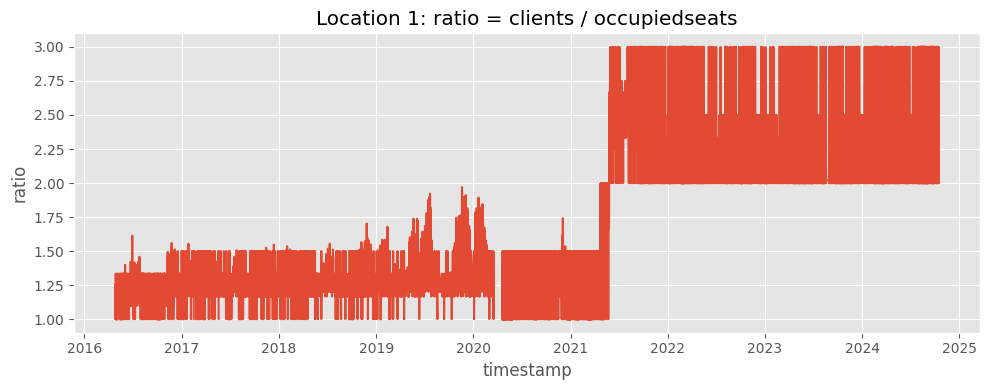

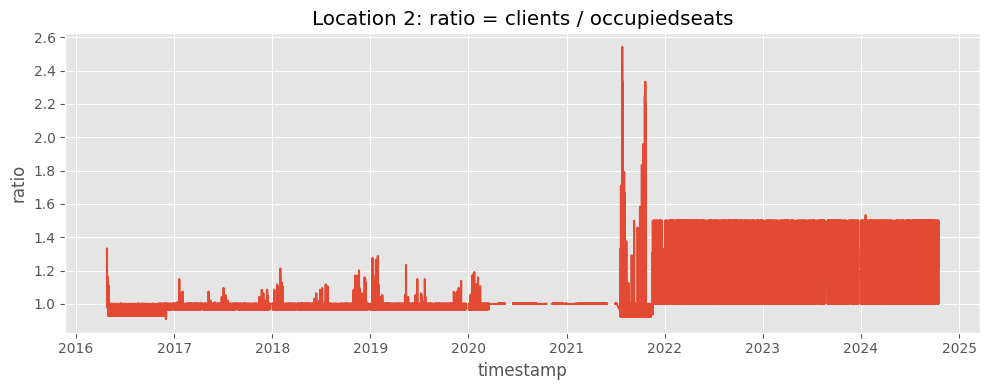

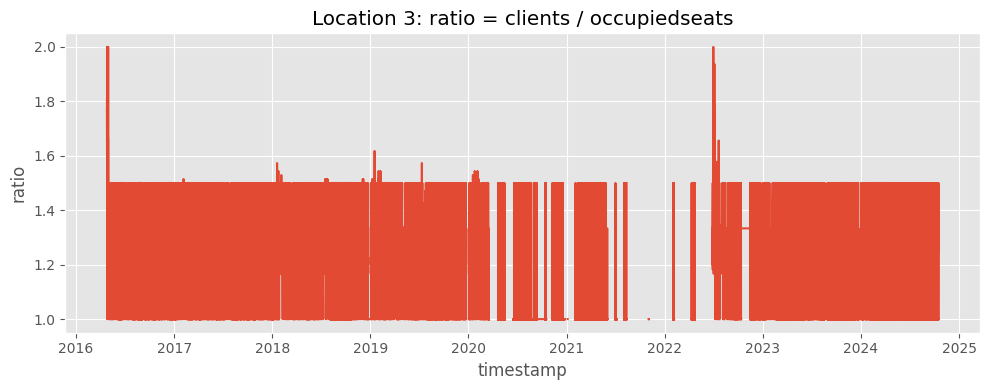

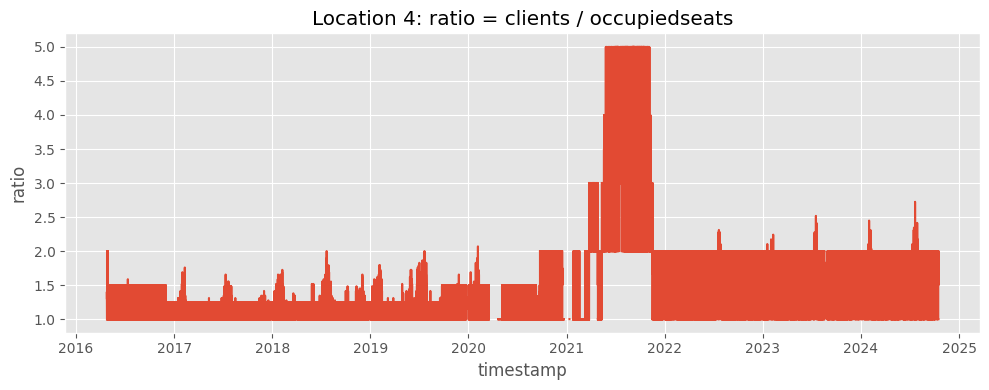

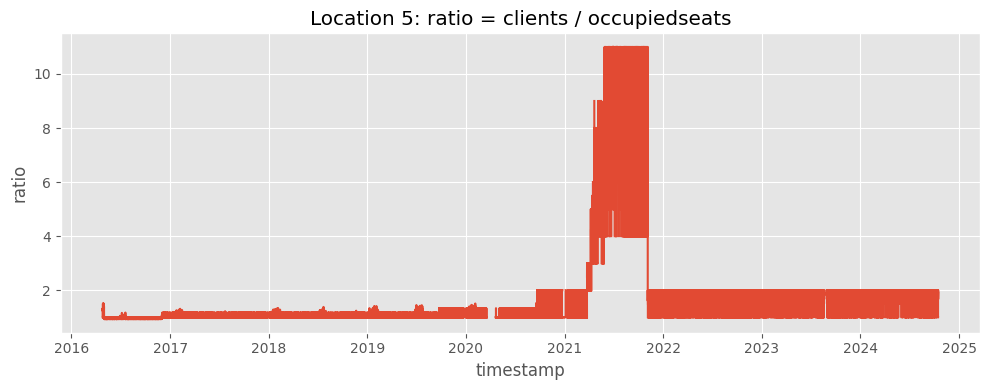

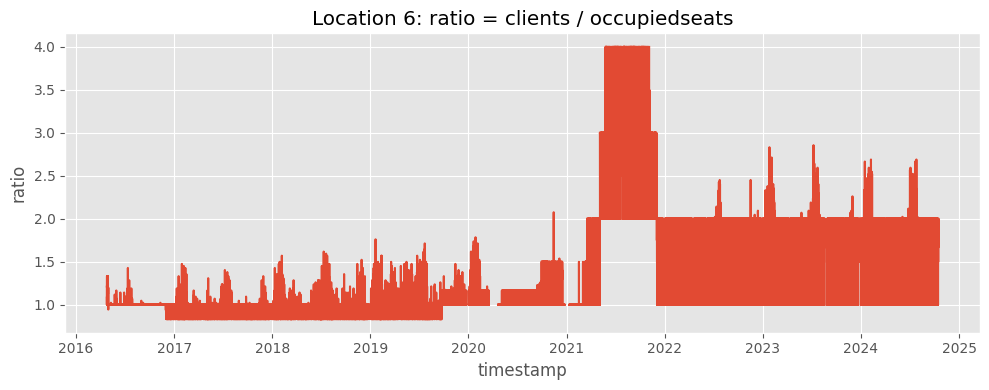

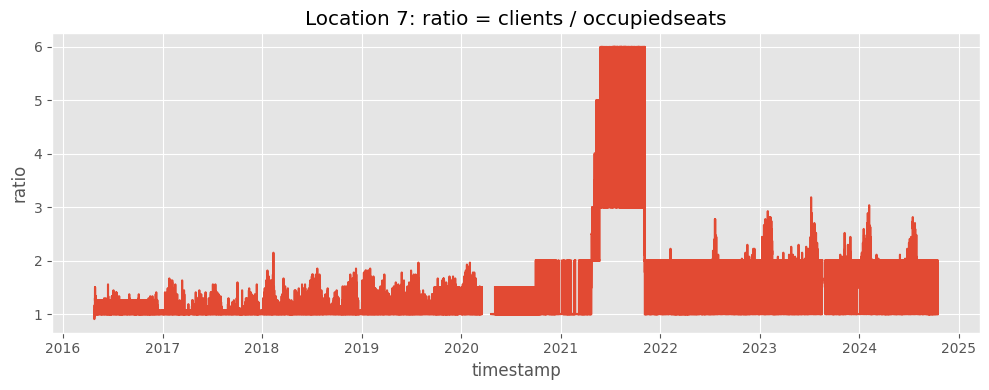

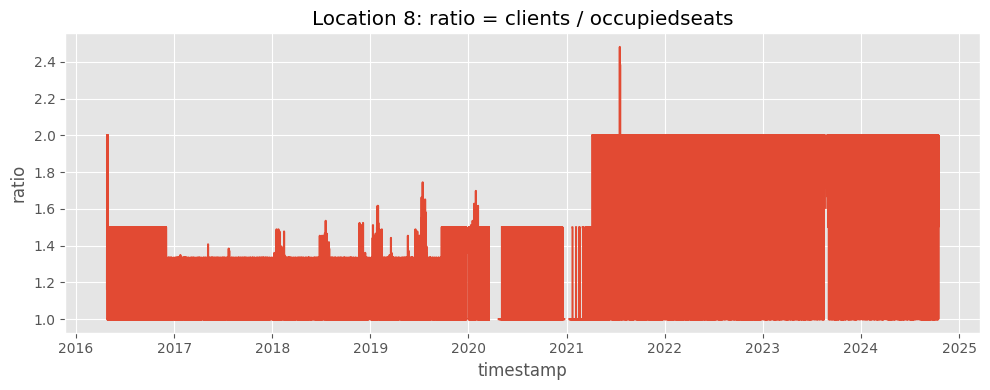

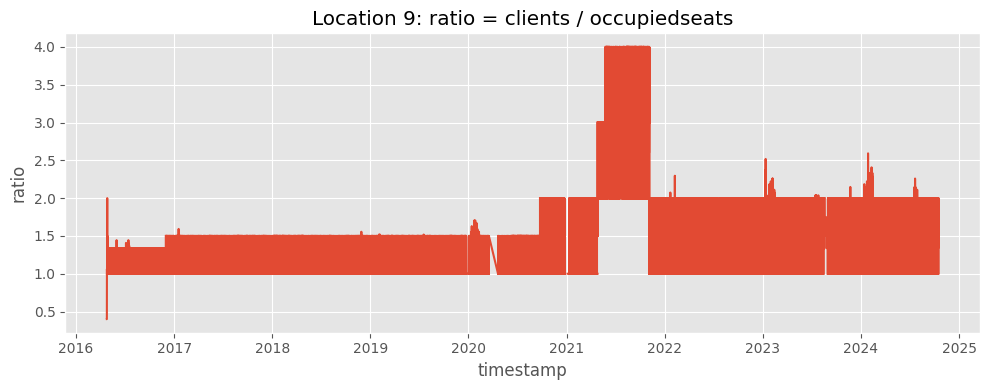

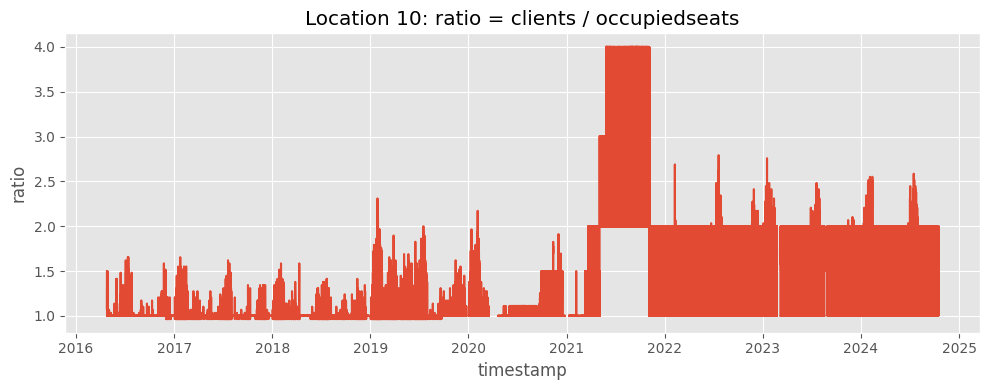

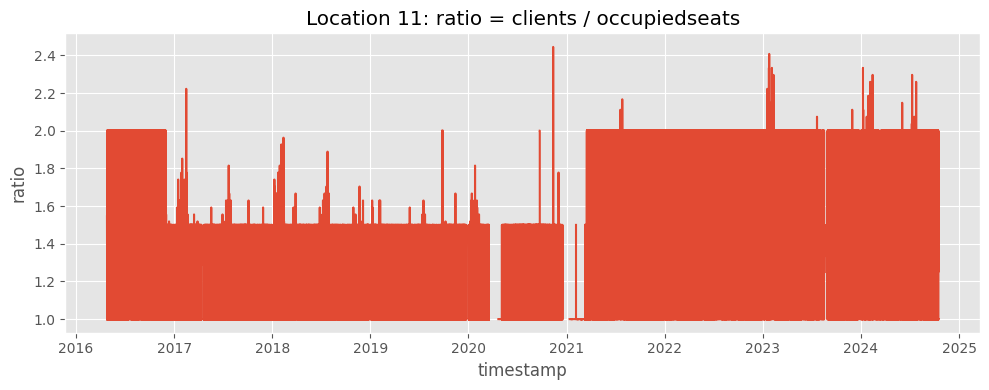

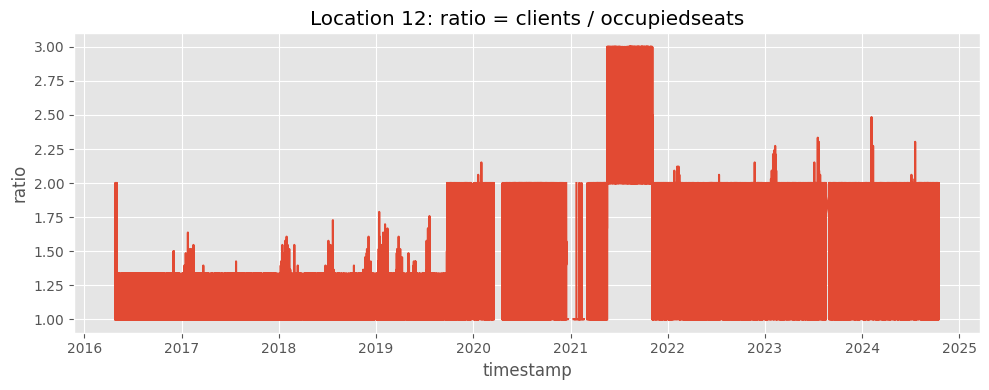

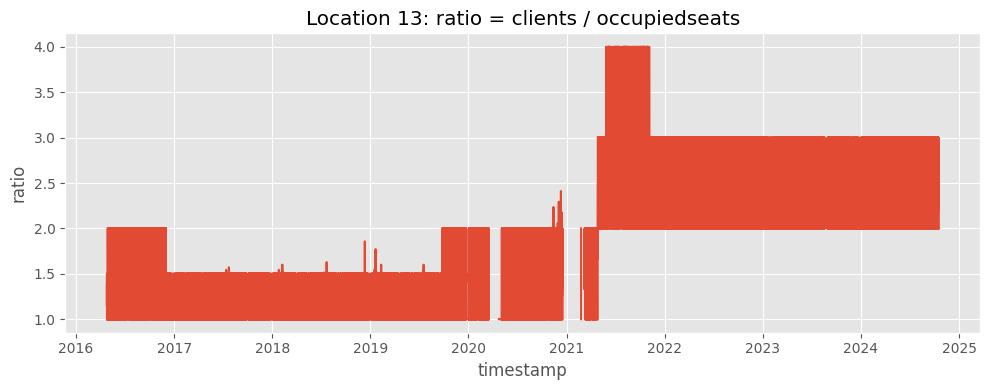

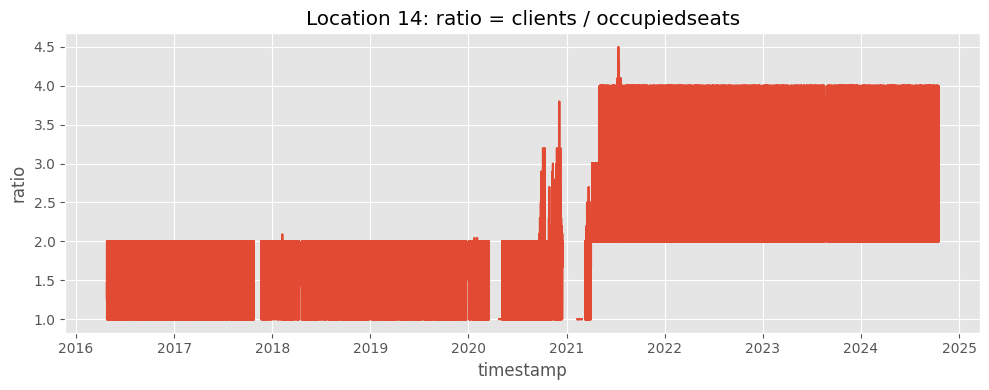

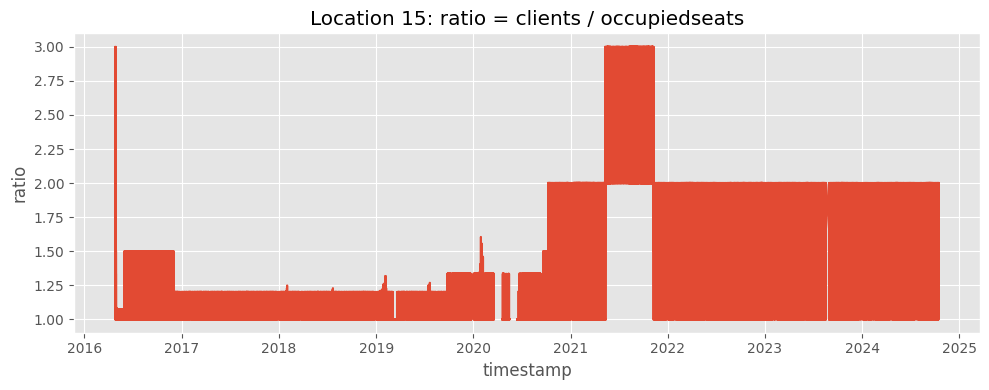

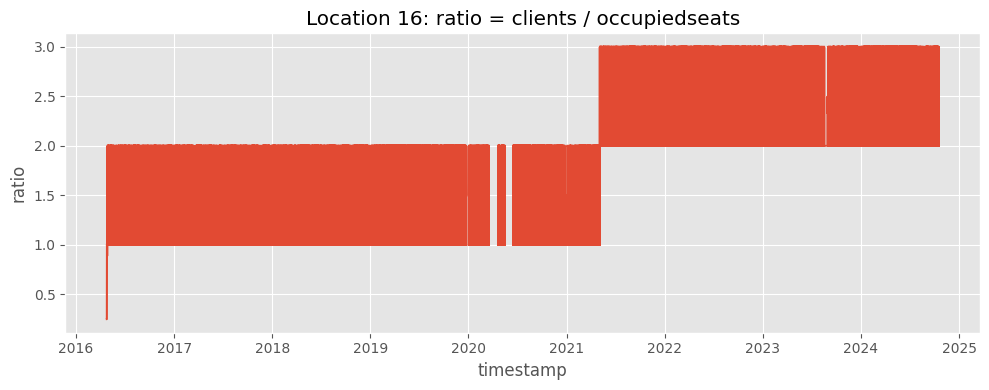

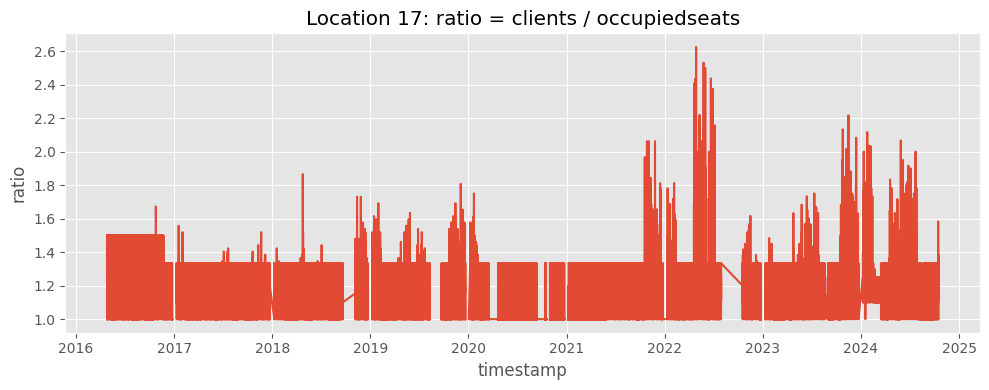

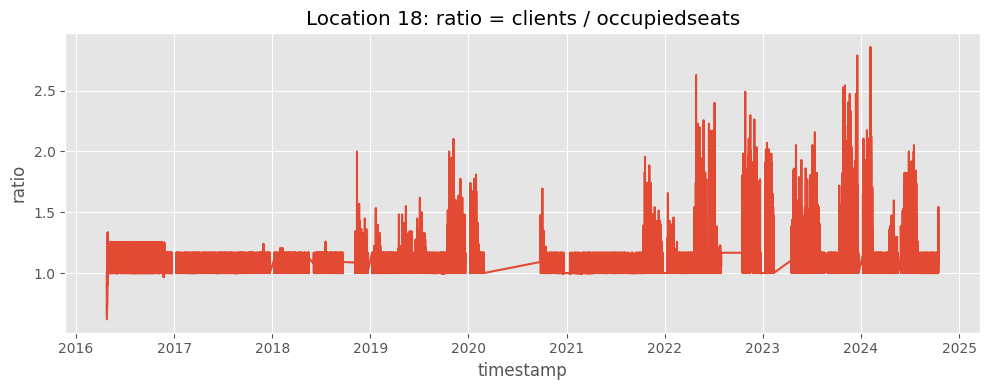

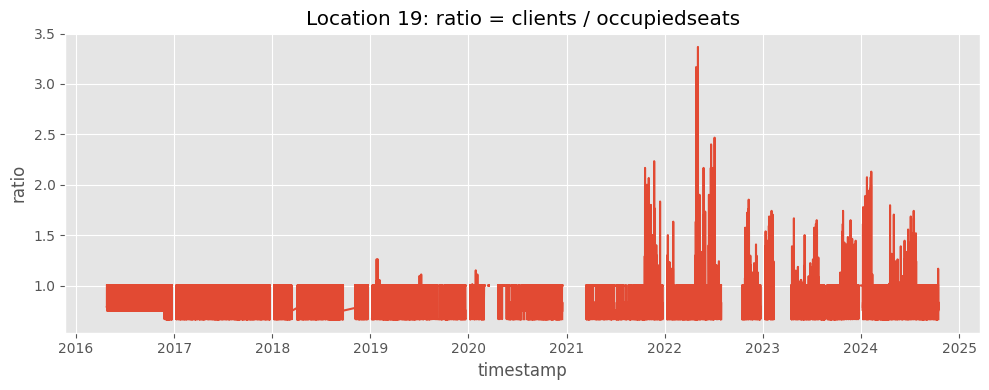

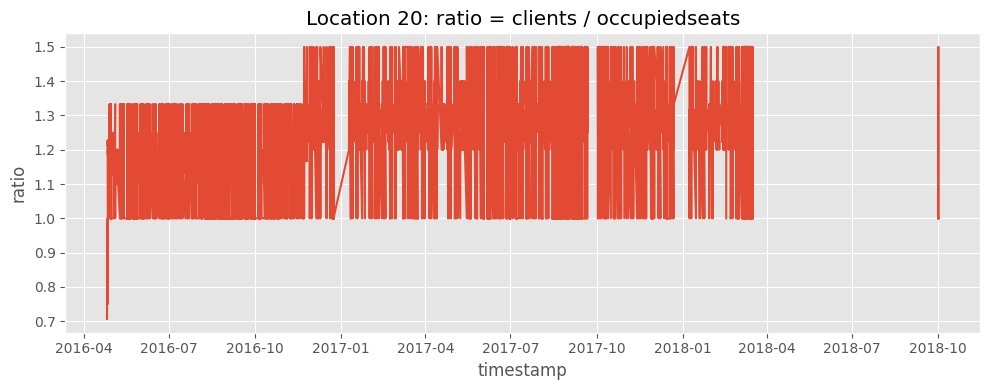

In [53]:

for loc in df_clients_seats["location_id"].unique():
    sub = df_clients_seats[df_clients_seats["location_id"] == loc]

    plt.figure(figsize=(10,4))
    plt.plot(sub["timestamp"], sub["ratio"])
    plt.title(f"Location {loc}: ratio = clients / occupiedseats")
    plt.xlabel("timestamp")
    plt.ylabel("ratio")
    plt.tight_layout()
    plt.show()


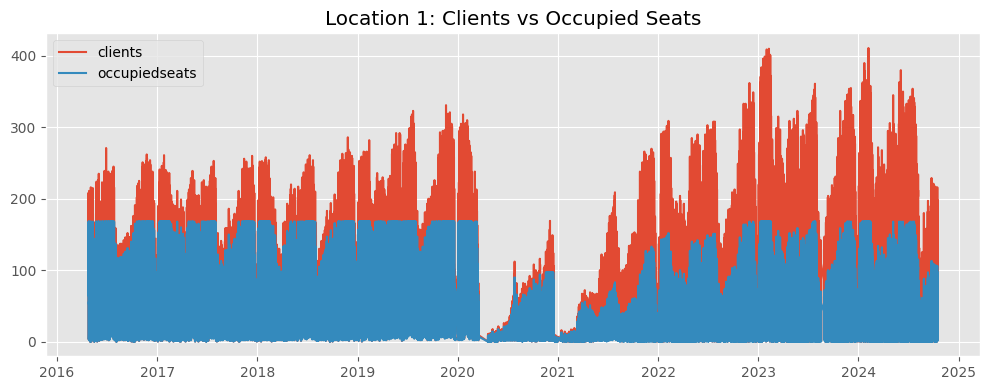

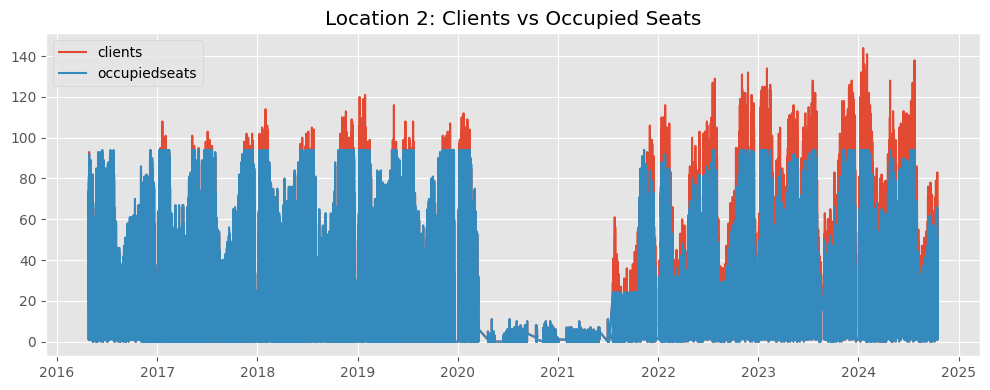

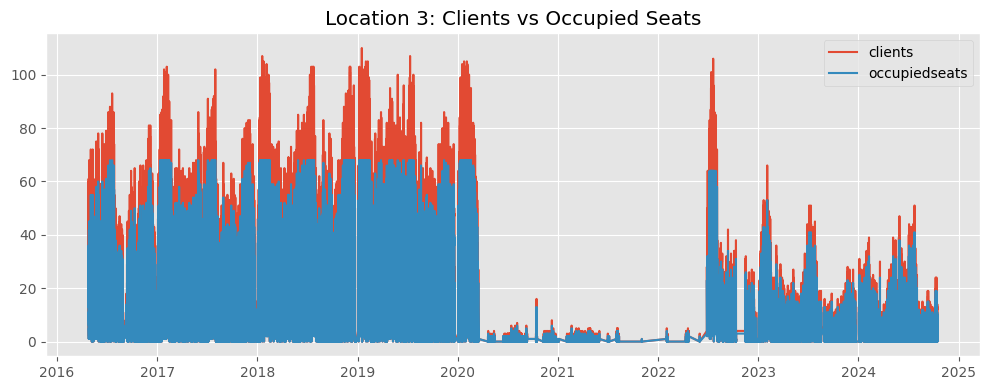

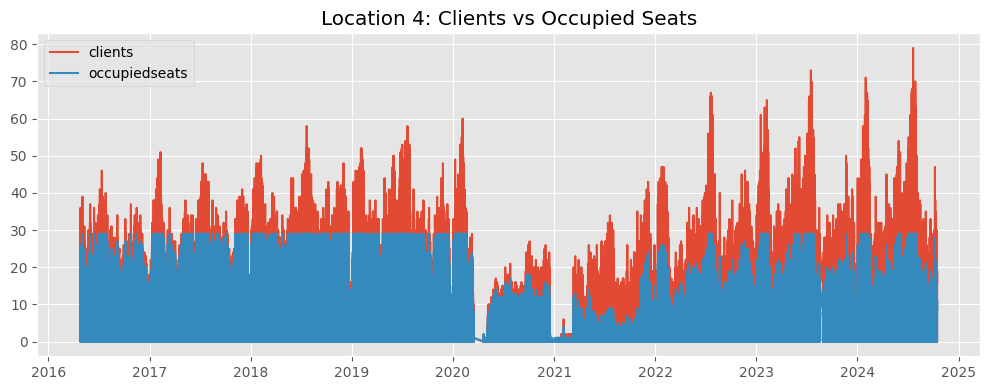

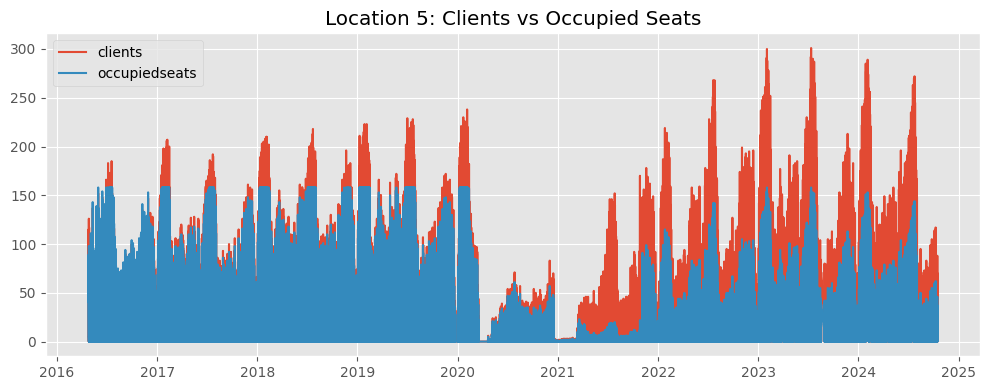

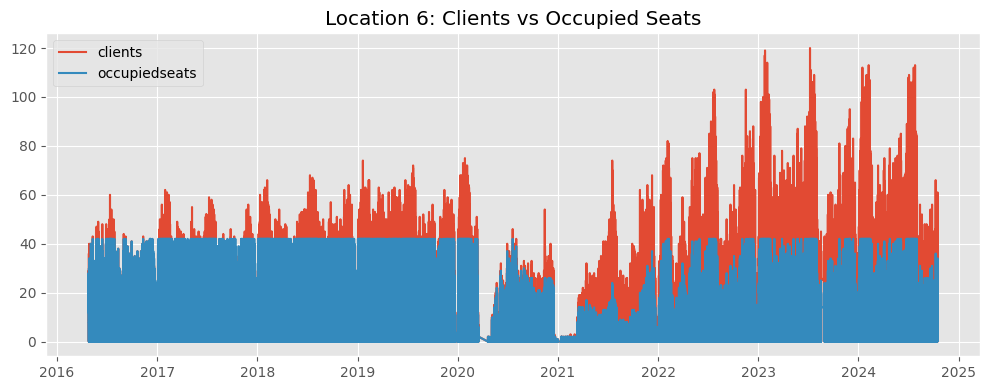

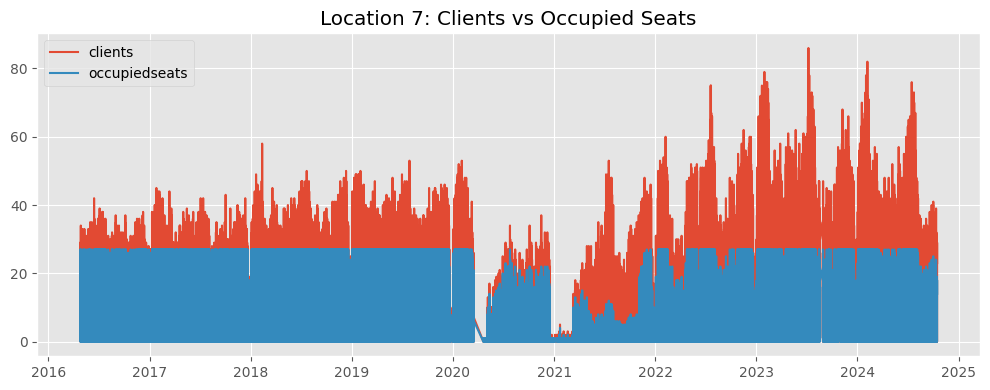

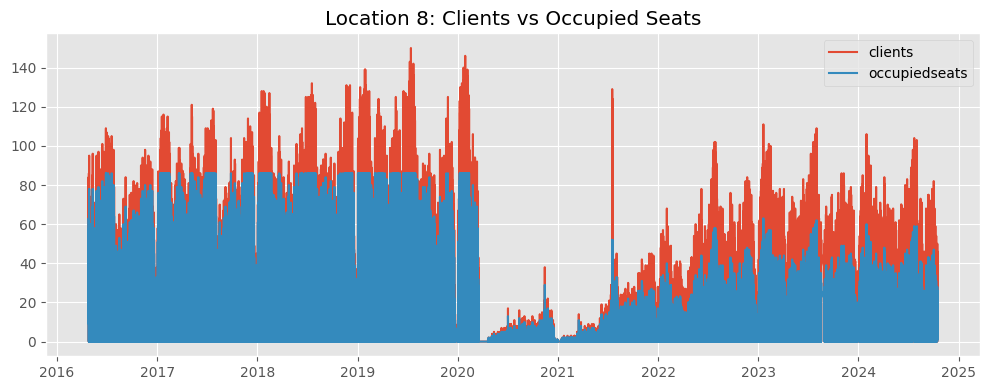

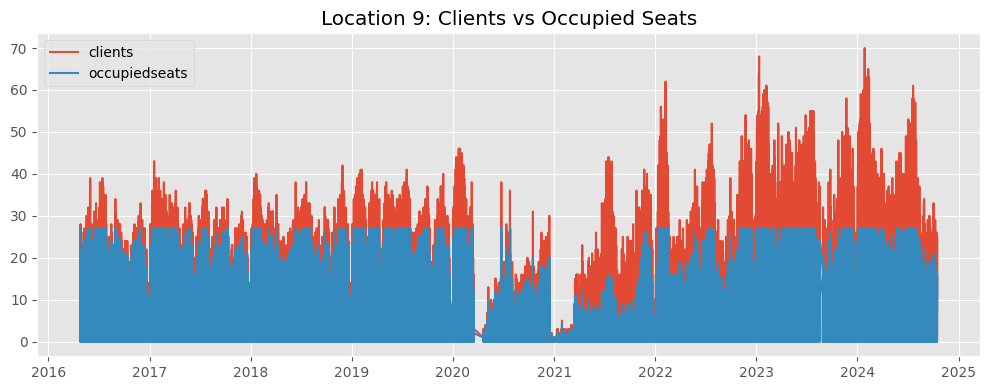

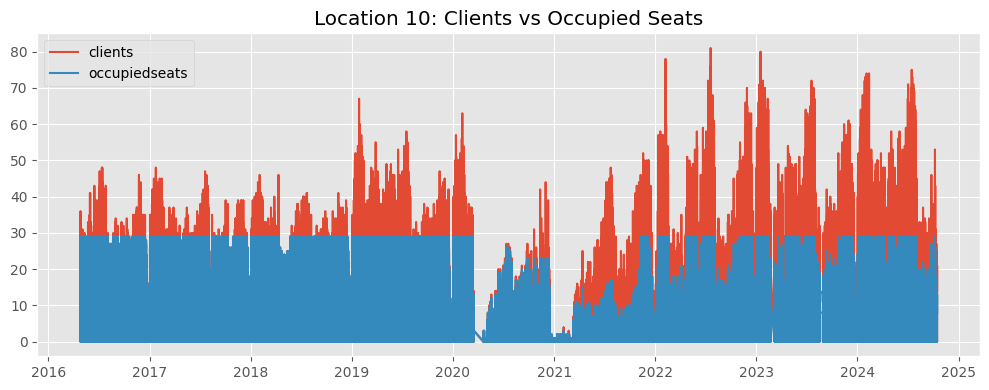

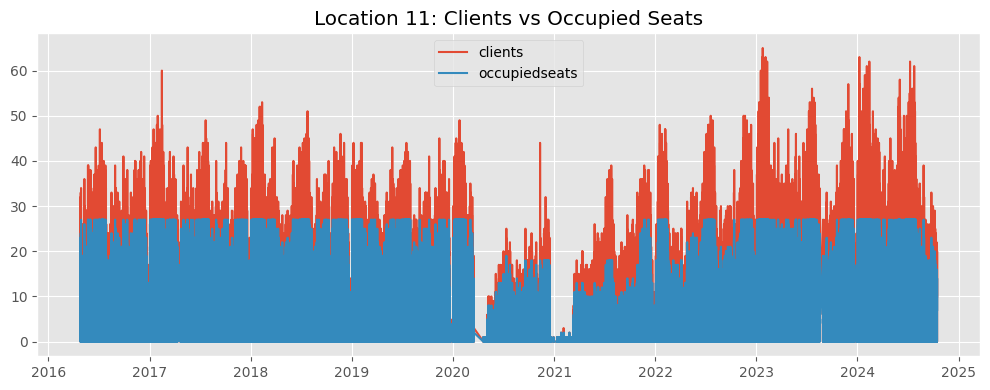

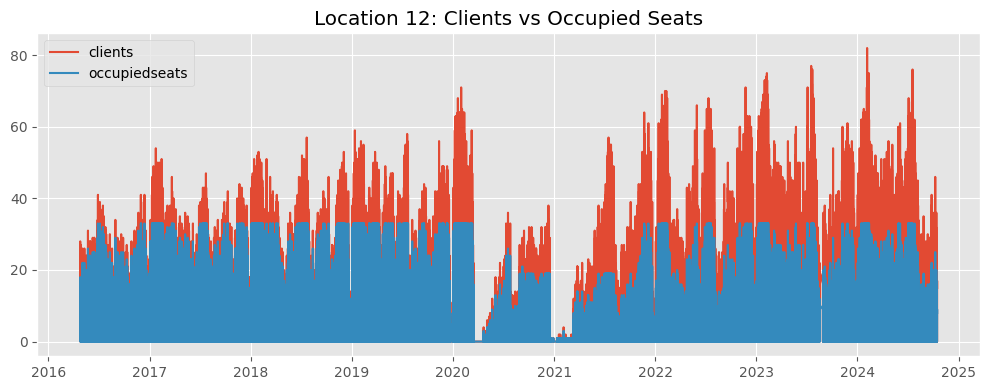

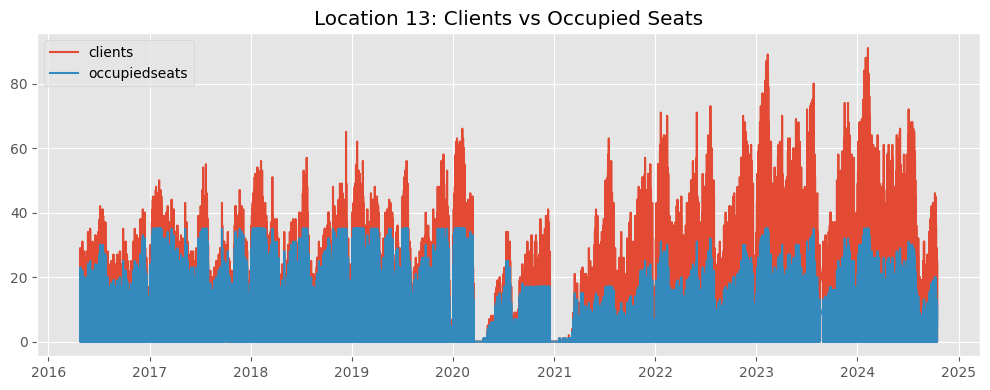

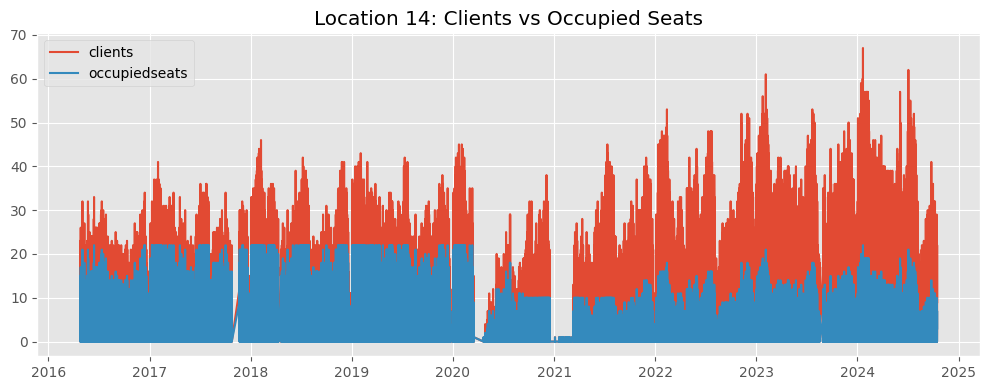

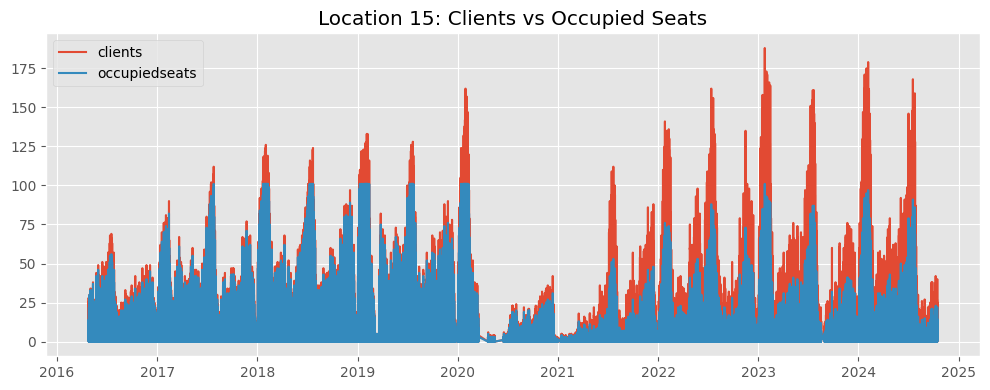

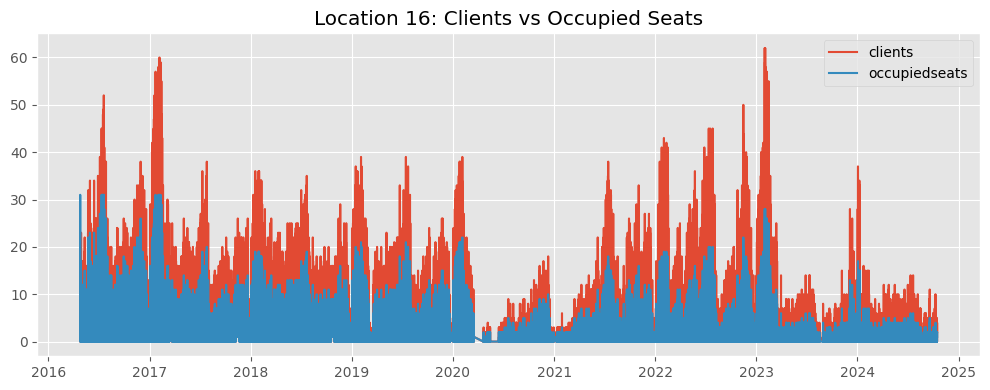

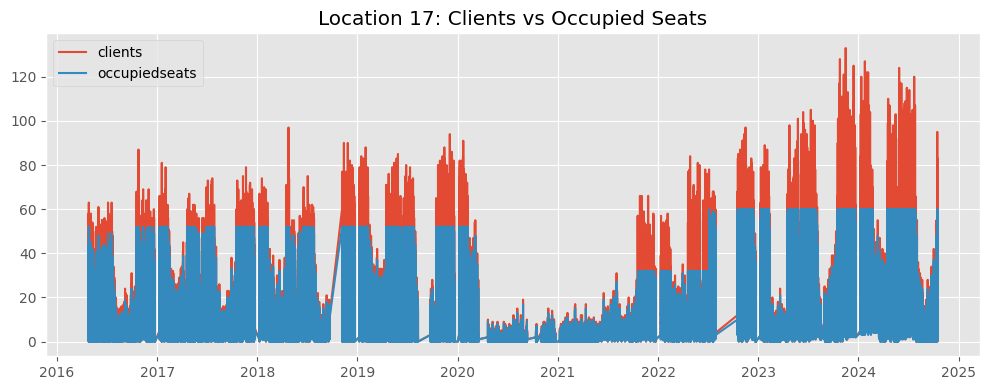

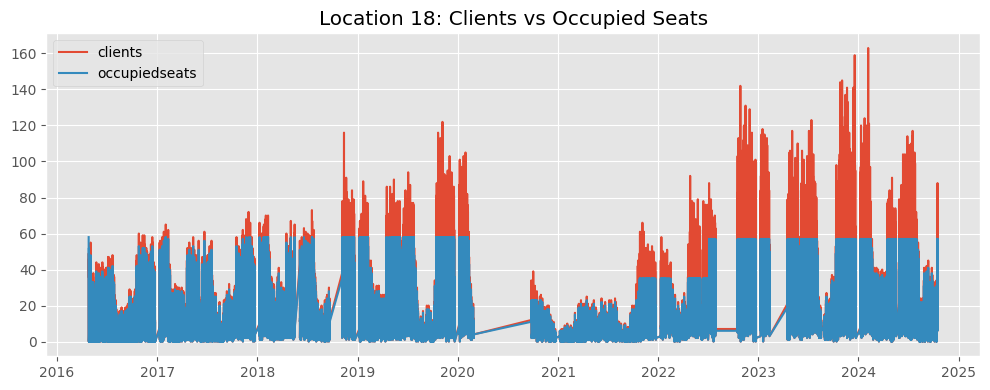

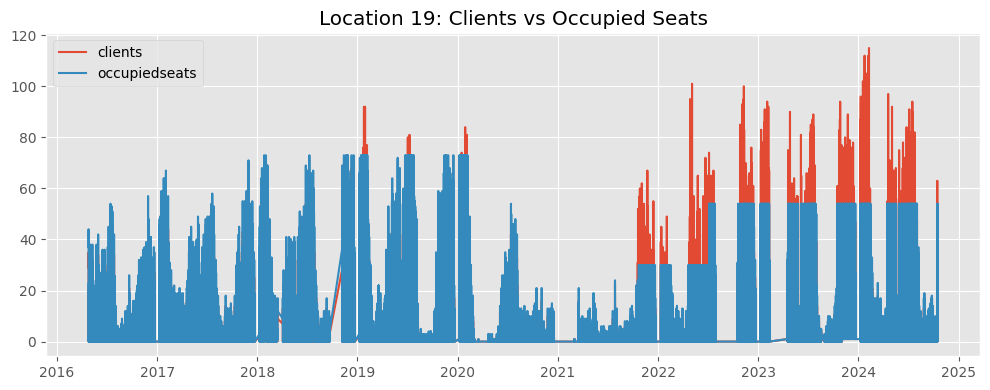

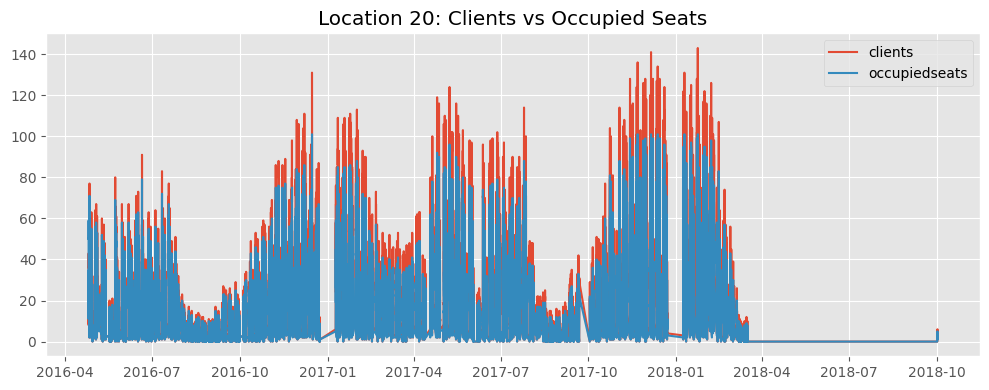

In [55]:
for loc in df_clients_seats["location_id"].unique():
    sub = df_clients_seats[df_clients_seats["location_id"] == loc]

    plt.figure(figsize=(10,4))
    plt.plot(sub["timestamp"], sub["numberofclients"], label="clients")
    plt.plot(sub["timestamp"], sub["occupiedseats"], label="occupiedseats")
    plt.title(f"Location {loc}: Clients vs Occupied Seats")
    plt.legend()
    plt.tight_layout()
    plt.show()


## Questions:
1. What is the proportional factor?
2. Did it change over time?
3. Is there a different proportional factor for every library?
4. Do we see an increase of used devices over time?
5. If there is a different factor for different librarys - does that mean that in specific librarys peoplen tend to have less/more device?

## things to keep in mind
1. Looking at the time increments (matching time steps?)
2. Looking at the nights (not opening hours) - did they just set the occupancy to zero? (then we have to remove the closed hours from the factor calculation.

## Roadmap
1. Trying to reverce engeneer the current factor for one library first (to see how it works the best)
2. Analysing the change of the factor over time for the last 10 years
3. do this for every library (opening hours may change and also changed over the years)
4. compare the progression and the factors for the different librarys
   

# just ignore form here ;)

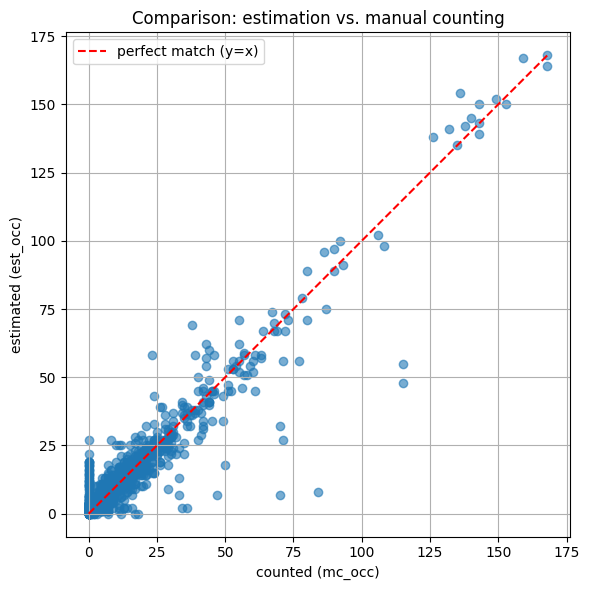

In [11]:
plt.figure(figsize=(6,6))
plt.scatter(qual["mc_occ"], qual["est_occ"], alpha=0.6)
min_val = min(qual["mc_occ"].min(), qual["est_occ"].min())
max_val = max(qual["mc_occ"].max(), qual["est_occ"].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="perfect match (y=x)")
plt.xlabel("counted (mc_occ)")
plt.ylabel("estimated (est_occ)")
plt.title("Comparison: estimation vs. manual counting")
plt.legend()
plt.tight_layout()
plt.show()


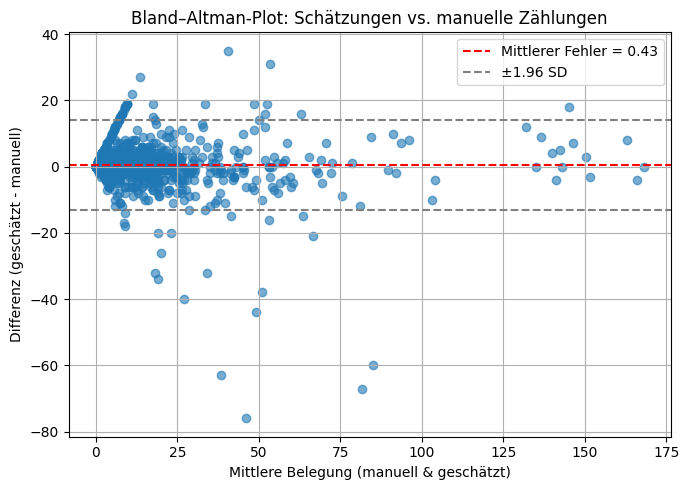

In [12]:
qual["mean_occ"] = (qual["mc_occ"] + qual["est_occ"]) / 2
qual["diff"] = qual["est_occ"] - qual["mc_occ"]

mean_diff = qual["diff"].mean()
sd_diff = qual["diff"].std()

plt.figure(figsize=(7,5))
plt.scatter(qual["mean_occ"], qual["diff"], alpha=0.6)
plt.axhline(mean_diff, color='red', linestyle='--', label=f'Mittlerer Fehler = {mean_diff:.2f}')
plt.axhline(mean_diff + 1.96*sd_diff, color='gray', linestyle='--', label='±1.96 SD')
plt.axhline(mean_diff - 1.96*sd_diff, color='gray', linestyle='--')
plt.xlabel("Mittlere Belegung (manuell & geschätzt)")
plt.ylabel("Differenz (geschätzt - manuell)")
plt.title("Bland–Altman-Plot: Schätzungen vs. manuelle Zählungen")
plt.legend()
plt.tight_layout()
plt.show()


In [13]:

bias = qual["diff"].mean()
mae = np.mean(np.abs(qual["diff"]))
rmse = np.sqrt(np.mean(qual["diff"]**2))
corr = qual["mc_occ"].corr(qual["est_occ"])

print(f"Bias (mean error): {bias:.2f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"Correlation: {corr:.3f}")


Bias (mean error): 0.43
MAE: 3.61
RMSE: 6.93
Correlation: 0.950


#### Confidence Intervall with Bootstrap

In [17]:
print(qual["diff"].describe())
print("n =", len(qual))


count    1166.00000
mean        0.43482
std         6.91807
min       -76.00000
25%        -1.00000
50%         1.00000
75%         2.00000
max        35.00000
Name: diff, dtype: float64
n = 1166


In [14]:
diff = qual["diff"].dropna().to_numpy()
n_boot = 10000
boot_means = [np.mean(np.random.choice(diff, size=len(diff), replace=True)) for _ in range(n_boot)]
ci_lower, ci_upper = np.percentile(boot_means, [2.5, 97.5])

print(f"Bootstrap 95% CI for mean difference: [{ci_lower:.2f}, {ci_upper:.2f}]")


Bootstrap 95% CI for mean difference: [0.03, 0.82]


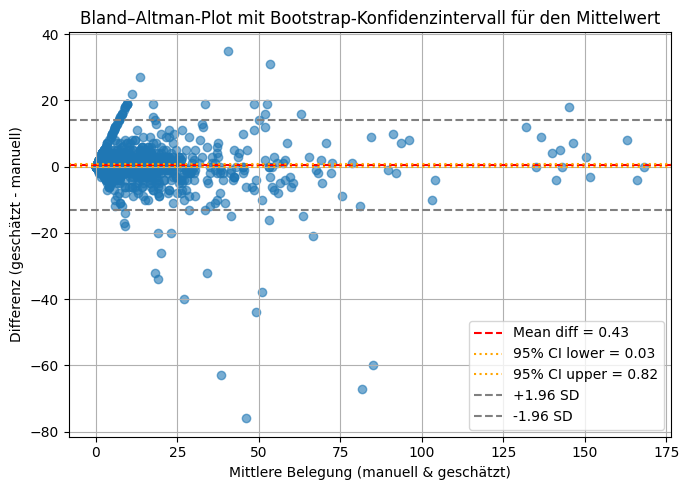

In [16]:

plt.figure(figsize=(7,5))
plt.scatter(qual["mean_occ"], qual["diff"], alpha=0.6)

# Mean bias
plt.axhline(mean_diff, color='red', linestyle='--', label=f'Mean diff = {mean_diff:.2f}')

# 95% bootstrap CI for the mean bias
plt.axhline(ci_lower, color='orange', linestyle=':', label=f'95% CI lower = {ci_lower:.2f}')
plt.axhline(ci_upper, color='orange', linestyle=':', label=f'95% CI upper = {ci_upper:.2f}')

# Limits of agreement (±1.96 SD)
plt.axhline(mean_diff + 1.96*sd_diff, color='gray', linestyle='--', label='+1.96 SD')
plt.axhline(mean_diff - 1.96*sd_diff, color='gray', linestyle='--', label='-1.96 SD')

plt.xlabel("Mittlere Belegung (manuell & geschätzt)")
plt.ylabel("Differenz (geschätzt - manuell)")
plt.title("Bland–Altman-Plot mit Bootstrap-Konfidenzintervall für den Mittelwert")
plt.legend()
plt.tight_layout()
plt.show()


/var/folders/9t/s3bwp7yx0j15db_p91_vyh680000gn/T/ipykernel_91787/1049649953.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = qual.groupby("bin").agg(


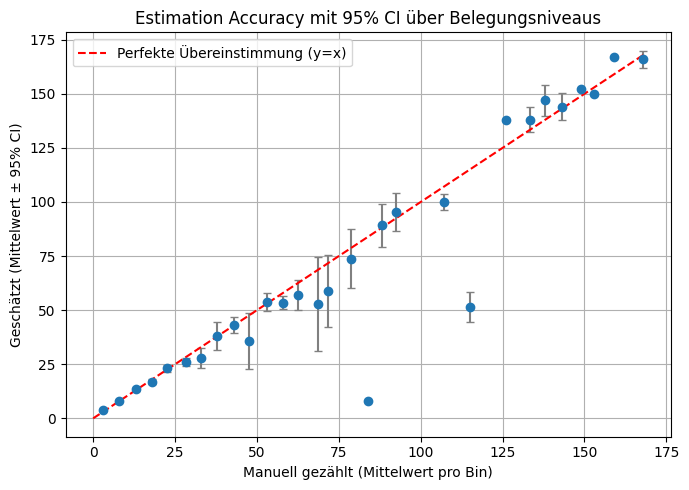

In [20]:

# Bin manual counts (for smoother error bars)
bins = np.arange(0, qual["mc_occ"].max()+10, 5)
qual["bin"] = pd.cut(qual["mc_occ"], bins)

# Compute mean and std in each bin
summary = qual.groupby("bin").agg(
    mean_mc=("mc_occ", "mean"),
    mean_est=("est_occ", "mean"),
    std_est=("est_occ", "std"),
    count=("est_occ", "count")
)

# Compute 95% confidence interval
summary["ci95"] = 1.96 * summary["std_est"] / np.sqrt(summary["count"])

plt.figure(figsize=(7,5))
plt.errorbar(summary["mean_mc"], summary["mean_est"],
             yerr=summary["ci95"], fmt='o', ecolor='gray', capsize=3)
plt.plot([0, summary["mean_mc"].max()], [0, summary["mean_mc"].max()], 'r--', label="Perfekte Übereinstimmung (y=x)")
plt.xlabel("Manuell gezählt (Mittelwert pro Bin)")
plt.ylabel("Geschätzt (Mittelwert ± 95% CI)")
plt.title("Estimation Accuracy mit 95% CI über Belegungsniveaus")
plt.legend()
plt.tight_layout()
plt.show()


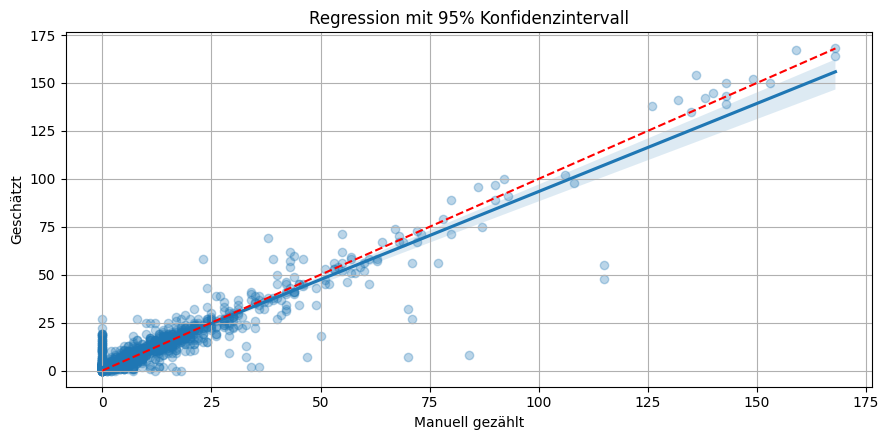

In [27]:

sns.regplot(data=qual, x="mc_occ", y="est_occ", ci=95, scatter_kws={'alpha':0.3})
plt.plot([0, qual["mc_occ"].max()], [0, qual["mc_occ"].max()], 'r--')
plt.xlabel("Manuell gezählt")
plt.ylabel("Geschätzt")
plt.title("Regression mit 95% Konfidenzintervall")
plt.tight_layout()
plt.show()


/var/folders/9t/s3bwp7yx0j15db_p91_vyh680000gn/T/ipykernel_91787/2597378191.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  resid_summary = qual.groupby("bin").agg(
/Users/laurasand/Documents/Master Informatik/data-literacy-2025-UT/dl/lib/python3.14/site-packages/pandas/core/groupby/generic.py:324: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  f = lambda x: func(x, *args, **kwargs)


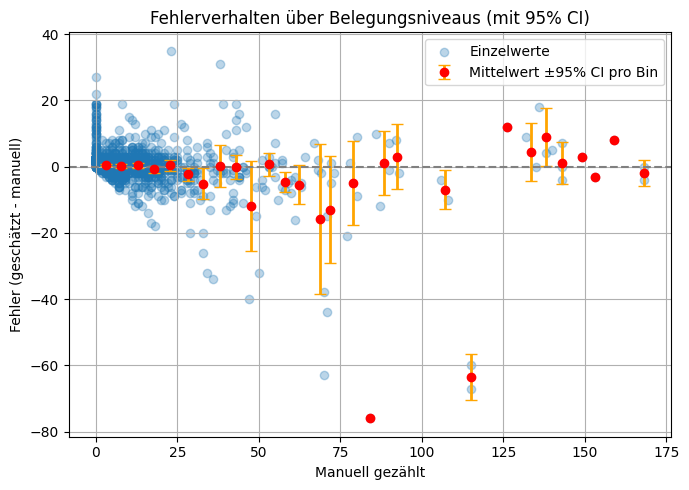

In [24]:
from scipy.stats import sem

bins = np.arange(0, qual["mc_occ"].max()+10, 5)
qual["bin"] = pd.cut(qual["mc_occ"], bins)

resid_summary = qual.groupby("bin").agg(
    mean_mc=("mc_occ", "mean"),
    mean_diff=("diff", "mean"),
    ci95=("diff", sem)
)
resid_summary["ci95"] *= 1.96

plt.figure(figsize=(7,5))
plt.scatter(qual["mc_occ"], qual["diff"], alpha=0.3, label="Einzelwerte")
plt.errorbar(resid_summary["mean_mc"], resid_summary["mean_diff"],
             yerr=resid_summary["ci95"], fmt='o', color='red',
             ecolor='orange', elinewidth=2, capsize=4, label='Mittelwert ±95% CI pro Bin')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Manuell gezählt")
plt.ylabel("Fehler (geschätzt - manuell)")
plt.title("Fehlerverhalten über Belegungsniveaus (mit 95% CI)")
plt.legend()
plt.tight_layout()
plt.show()


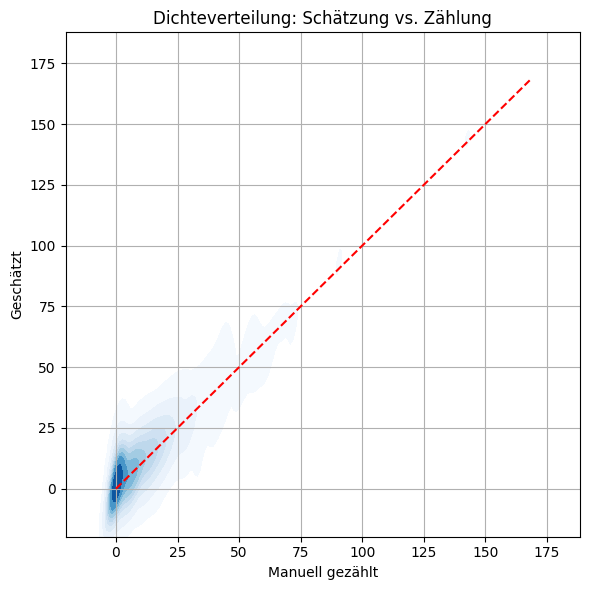

In [25]:

plt.figure(figsize=(6,6))
sns.kdeplot(x=qual["mc_occ"], y=qual["est_occ"], fill=True, cmap="Blues", thresh=0.05)
plt.plot([0, qual["mc_occ"].max()], [0, qual["mc_occ"].max()], 'r--')
plt.xlabel("Manuell gezählt")
plt.ylabel("Geschätzt")
plt.title("Dichteverteilung: Schätzung vs. Zählung")
plt.tight_layout()
plt.show()


## looking into lowest correlation locations 


---

### Appendix: Nützliche Helfer

- `loc_lookup`: Mapping von `location_id` → `(name, longname, availableseats)`  
- Beispiel: `loc_lookup.loc[19]`
